# Analyse de l'impact de la météo et du télétravail sur l'usage du vélo à Paris



Ce projet analyse l'évolution du trafic cyclable à Paris entre 2018 et 2024 à partir des données de comptage vélo en libre accès fournies par la Ville de Paris. L'objectif est de quantifier l'impact de deux facteurs majeurs sur les déplacements à vélo : les conditions météorologiques et l'essor du télétravail post-COVID.


Plus précisément, nous cherchons à répondre aux questions suivantes :
1. Quel est l'impact quantitatif de la température, des précipitations et de la couverture nuageuse sur le nombre de passages vélo ?
2. Le télétravail a-t-il modifié structurellement les patterns hebdomadaires de déplacement à vélo ?
3. Quelle est la part des trajets domicile-travail dans le trafic vélo total et comment a-t-elle évolué ?

**Motivations :** 

Paris a connu une croissance spectaculaire de l'usage du vélo ces dernières années, notamment grâce aux politiques volontaristes de la Ville (plan vélo 2015-2020, coronapistes, développement des pistes cyclables). Le vélo est devenu un mode de transport structurant dans la capitale.

- Planification urbaine : Comprendre les facteurs influençant l'usage du vélo permet d'optimiser les aménagements cyclables ;
- Politiques publiques : Identifier les freins (météo) et les leviers (infrastructures) pour encourager la pratique du vélo ;
- Évolution des mobilités : Le télétravail post-COVID a profondément modifié les habitudes de déplacement.

Ce projet permet d'appliquer des techniques d'analyse de données modernes (nettoyage de données volumineuses, régression économétrique, visualisation) sur un cas d'usage concret avec des données réelles en open data.

**Méthodologie :**

- Sources : Open Data Ville de Paris ([Paris Data](https://opendata.paris.fr)) et Open Meteo ([Meto Data](https://open-meteo.com/)) ;
- Période : 2018-2024 (7 ans).

**Références :**

- Héran, F. (2015), *Le retour de la bicyclette : Une histoire des déplacements urbains en Europe, de 1817 à 2050* ;
- Pucher, J., & Buehler, R. (2017), « Cycling towards a more sustainable transport future », *Transport Reviews*, 37(6), 689-694 ;
- Fishman, E. (2016), « Cycling as transport », *Transport Reviews*, 36(1), 1-8.

## Partie 1 : données sur la circulation des vélos dans Paris de 2018 à 2024

### Configuration de l'environnement

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import glob
import gzip
import shutil
import warnings
from shapely.geometry import Point
import geopandas as gpd
import re
import statsmodels.api as sm

warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

from fonctions import *

### Chargement des données 2018-2024

Chargement optimisé de l'historique du trafic vélo à Paris (2018-2024).

La fonction "load_or_create_parquet()" :
- Charge le fichier parquet s'il existe (rapide)
- Sinon, consolide tous les CSV et crée le fichier parquet
- Le format parquet est plus rapide que CSV

In [9]:
DATA_DIR = "data"
PARQUET_HISTORIQUE = f"{DATA_DIR}/velo_paris_historique.parquet"

df_historique = load_or_create_parquet(DATA_DIR, PARQUET_HISTORIQUE)

Fichier : data/velo_paris_historique.parquet


Lignes : 24,007,006
Colonnes : ['Identifiant du point de comptage', 'Nom du point de comptage', 'Comptage horaire', 'Date et heure de comptage', "Date d'installation du point de comptage", 'Lien vers photo du point de comptage', 'Coordonnées géographiques']
   Pour recréer : import os; os.remove('data/velo_paris_historique.parquet')


### Exploration des données

Chargement de l'historique vélo Paris (2018-2024) au format parquet, suivi d'une exploration statistique des données (aperçu, types, valeurs manquantes, période temporelle).

In [10]:
DATA_DIR = "data"
PARQUET_HISTORIQUE = f"{DATA_DIR}/velo_paris_historique.parquet"

df_historique = load_or_create_parquet(DATA_DIR, PARQUET_HISTORIQUE)

df_historique = explore_data(df_historique)

Fichier : data/velo_paris_historique.parquet


Lignes : 24,007,006
Colonnes : ['Identifiant du point de comptage', 'Nom du point de comptage', 'Comptage horaire', 'Date et heure de comptage', "Date d'installation du point de comptage", 'Lien vers photo du point de comptage', 'Coordonnées géographiques']
   Pour recréer : import os; os.remove('data/velo_paris_historique.parquet')
EXPLORATION DES DONNÉES

 INFORMATIONS GÉNÉRALES
Nombre total de lignes : 24,007,006
Nombre de colonnes : 7
Taille en mémoire : 16144.25 Mo

 COLONNES
1. Identifiant du point de comptage           24,007,006 valeurs (100.0%)
2. Nom du point de comptage                   24,007,006 valeurs (100.0%)
3. Comptage horaire                           24,007,006 valeurs (100.0%)
4. Date et heure de comptage                  24,007,006 valeurs (100.0%)
5. Date d'installation du point de comptage   24,007,006 valeurs (100.0%)
6. Lien vers photo du point de comptage       24,007,006 valeurs (100.0%)
7. Coordonnées géographiques                  24,007,006 valeurs (100.

**Dataset** : 24M observations, 98 compteurs, 2018-2024, 308M passages vélo

**Qualité** : Aucune donnée manquante, géolocalisation complète

**Trafic** : 
- Moyenne : 14.5 passages/h
- Médiane : 3 passages/h → distribution asymétrique
- Max : 4 132 passages/h

**Couverture** :
- Pic 2021-2022 (48.7% des données)
- Nécessité de filtrer sur compteurs constants pour analyses temporelles

### Analyse du trafic vélo à Paris

Analyse complète du trafic vélo parisien (2018-2024) avec trois visualisations :
1. Évolution mensuelle du trafic
2. Top 10 arrondissements par volume de passages
3. Compteurs constants (présents sur la période 2018-2024)

Affiche également les statistiques globales : période, nombre d'observations, total de passages.

Fichier : data/velo_paris_historique.parquet


Lignes : 24,007,006
Colonnes : ['Identifiant du point de comptage', 'Nom du point de comptage', 'Comptage horaire', 'Date et heure de comptage', "Date d'installation du point de comptage", 'Lien vers photo du point de comptage', 'Coordonnées géographiques']
   Pour recréer : import os; os.remove('data/velo_paris_historique.parquet')
Lignes de départ : 24,007,006

Conversion des dates...
   Converti : 24,007,006 / 24,007,006

Répartition par année :
  2017: 260 lignes
  2018: 2,271,177 lignes
  2019: 2,271,286 lignes
  2020: 2,315,833 lignes
  2021: 5,851,688 lignes
  2022: 5,885,976 lignes
  2023: 3,128,299 lignes
  2024: 2,282,487 lignes

Conversion des comptages...
  21,272,238 lignes valides

Parsing des coordonnées...
   21,187,287 lignes avec coordonnées

Calcul des arrondissements

DONNÉES FINALES
Lignes : 21,187,287
Période : 2017-12-31 23:00:00 → 2024-12-31 22:45:00
Arrondissements : [np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.

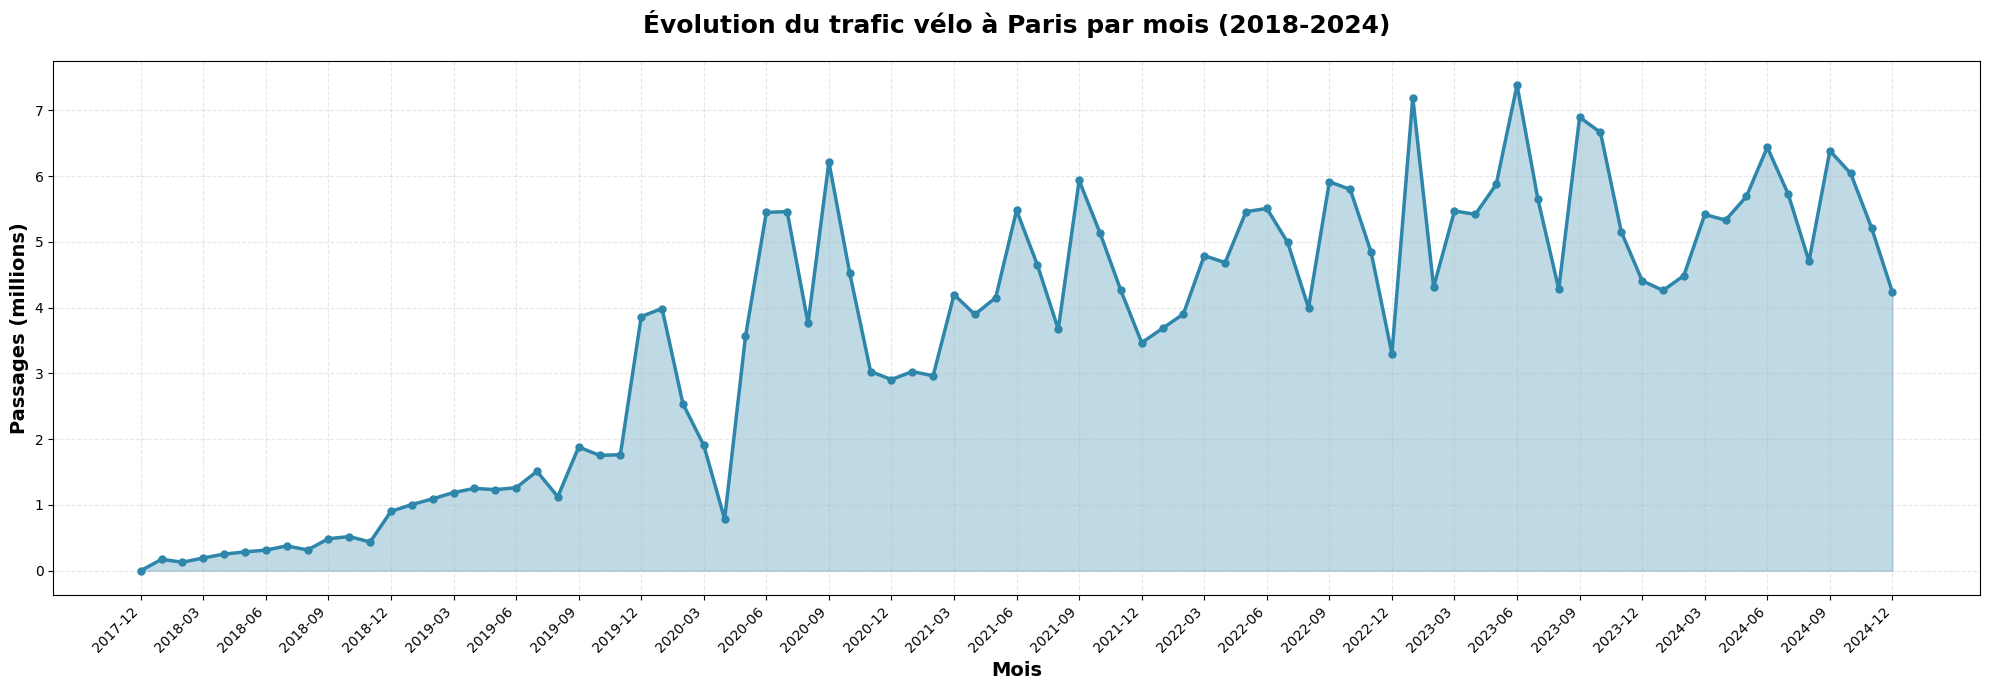


GRAPHIQUE 2 : TOP 10 ARRONDISSEMENTS

Classement des arrondissements (total 2018-2024) :
   1. 11e arr. :      42,532,608 passages (13.82%)
   2. 13e arr. :      32,084,757 passages (10.43%)
   3.  7e arr. :      31,121,703 passages (10.11%)
   4.  3e arr. :      29,904,281 passages ( 9.72%)
   5. 19e arr. :      23,160,305 passages ( 7.53%)
   6. 10e arr. :      22,071,246 passages ( 7.17%)
   7.  4e arr. :      19,505,830 passages ( 6.34%)
   8. 15e arr. :      19,322,151 passages ( 6.28%)
   9. 12e arr. :      17,470,309 passages ( 5.68%)
  10.  8e arr. :      15,367,061 passages ( 4.99%)


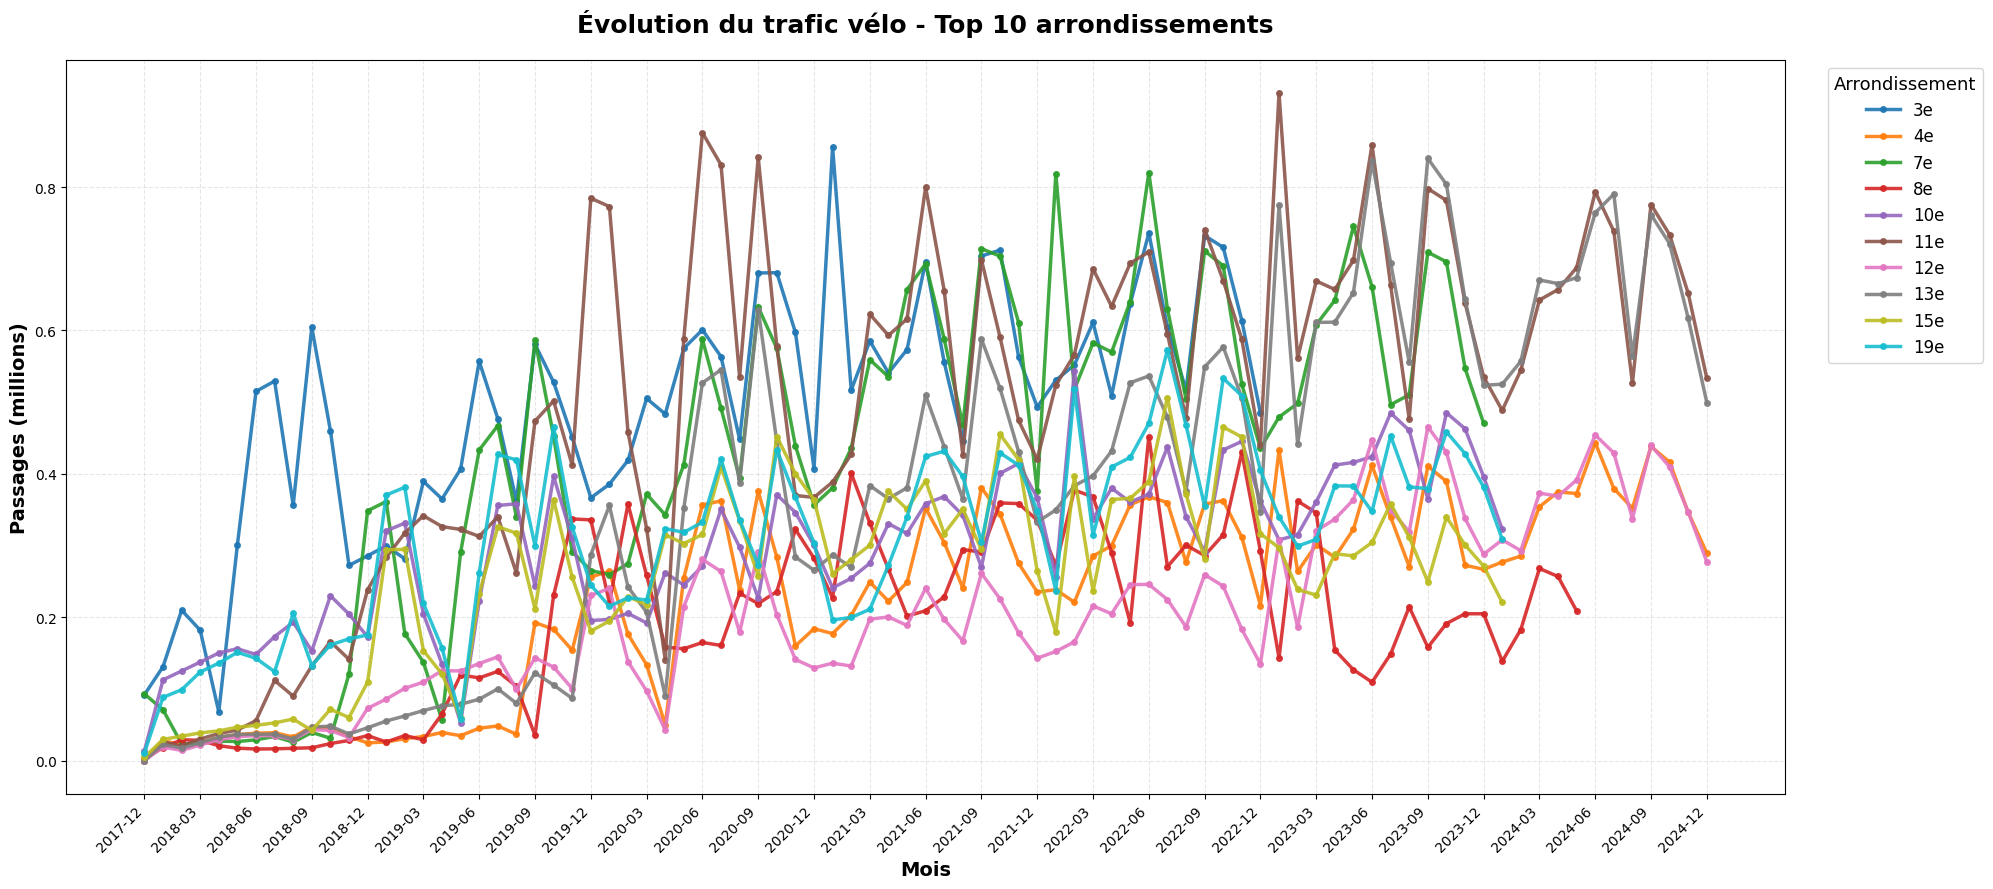


GRAPHIQUE 3 : ÉVOLUTION AVEC COMPTEURS CONSTANTS

Identification des compteurs constants
  Compteurs totaux : 98
  Compteurs constants (2018-2024) : 31
  Lignes avec compteurs constants : 9,291,537 / 21,187,287
  Pourcentage des données : 43.9%


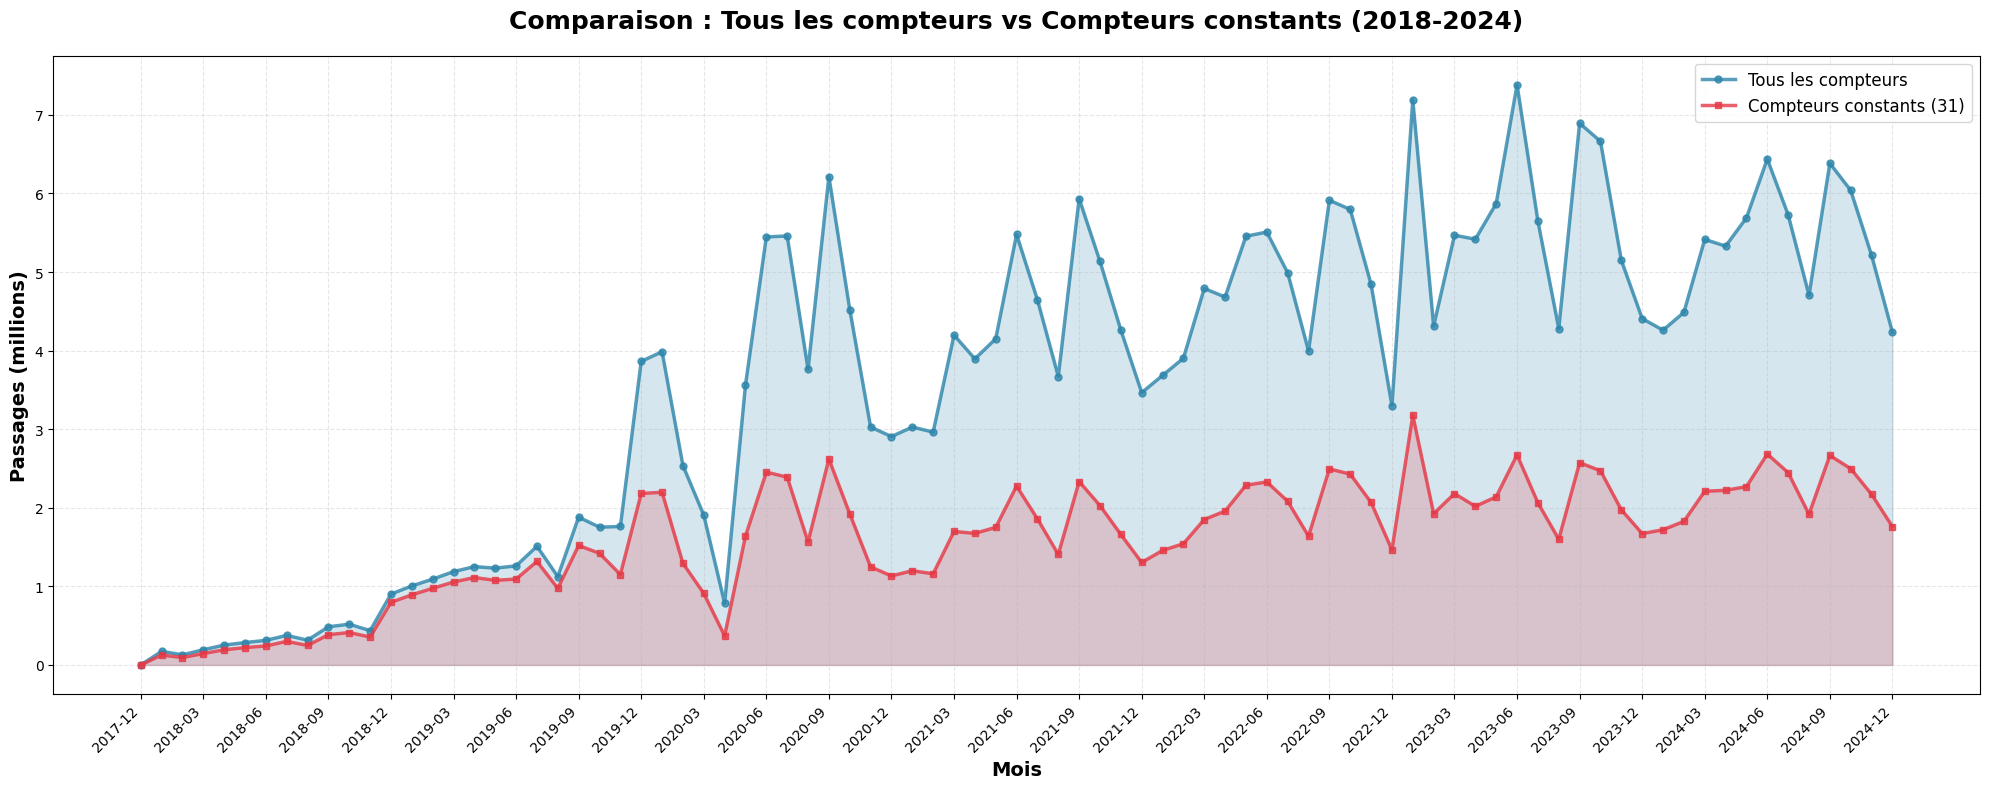


 Statistiques comparatives :

  Période analysée : 2017 - 2024

  Évolution annuelle (compteurs constants) :
    2017 :              23 passages (référence = base 100)
    2018 :       3,522,866 passages (indice 15316808.7, +15316708.7%)
    2019 :      14,775,923 passages (indice 64243143.5, +64243043.5%)
    2020 :      19,748,449 passages (indice 85862821.7, +85862721.7%)
    2021 :      20,352,656 passages (indice 88489808.7, +88489708.7%)
    2022 :      23,604,435 passages (indice 102627978.3, +102627878.3%)
    2023 :      26,468,854 passages (indice 115081973.9, +115081873.9%)
    2024 :      26,395,681 passages (indice 114763830.4, +114763730.4%)

  Indice final : 114763830.4 (base 100 en 2017)
  Croissance totale : +114763730.4%
  Croissance annuelle moyenne : +634.0%

ANALYSE COMPTEURS CONSTANTS TERMINÉE

ANALYSE TERMINÉE

Données analysées : 21,187,287 lignes
Période couverte : 2017 - 2024
Total de passages comptés : 307,715,957


In [11]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

DATA_DIR = "data"
PARQUET_HISTORIQUE = f"{DATA_DIR}/velo_paris_historique.parquet"

df_historique = load_or_create_parquet(DATA_DIR, PARQUET_HISTORIQUE)

df = analyze_bike_traffic(df_historique)
plot_monthly_evolution(df)
plot_top_arrondissements(df)
plot_constant_counters(df)

print("\n" + "="*80)
print("ANALYSE TERMINÉE")
print("="*80)
print(f"\nDonnées analysées : {len(df):,} lignes")
print(f"Période couverte : {df['annee'].min()} - {df['annee'].max()}")
print(f"Total de passages comptés : {df['comptage_num'].sum():,.0f}")

**Graphique 1 :**
- Tendance générale : Croissance spectaculaire du trafic vélo parisien
- Choc COVID-19 (mars-mai 2020) : Effondrement brutal du trafic lors du premier confinement, suivi d'un rebond rapide
- Pics hivernaux : Creux systématiques en janvier-février de chaque année.

**Graphique 2 :**
- Forte hétérogénéité du trafic vélo selon les zones de Paris, reflétant les différences d'aménagements cyclables, de densité de population et de trajets domicile-travail
- Convergence progressive des arrondissements au fil du temps, suggérant une démocratisation du vélo dans toute la capitale.

**Graphique 3 :**

Comparaison : 31 compteurs constants (rouge) vs tous les compteurs (bleu)

Résultat :
- Compteurs constants : croissance réelle ×3-4
- Tous compteurs : croissance apparente ×10-15

**Conclusion :** Le trafic vélo a vraiment augmenté, mais l'ajout de nouveaux compteurs amplifie artificiellement la croissance observée sur le graphique 1.

### Part du vélo-taff dans le trafic cyclable

Analyse spécifique des trajets domicile-travail :
- **Créneaux** : 7h-10h (matin) et 17h-20h (soir)
- **Période** : Jours ouvrés hors juillet-août
- **Visualisation** : Comparaison créneaux de pointe vs heures creuses


ANALYSE VÉLO-TAFF (trajets domicile-travail)

 Exclusion de juillet et août...
  Lignes supprimées : 3,612,536 (17.1%)
  Lignes restantes : 17,574,751

Créneaux horaires définis :
  • Vélo-taff matin : 7h-10h (lun-ven, hors juil-août)
  • Vélo-taff soir  : 17h-20h (lun-ven, hors juil-août)
  • Autres          : reste du temps

 Statistiques globales (2018-2024, lun-ven, hors juil-août) :
  • Vélo-taff matin :      37,858,974 passages ( 18.6%)
  • Vélo-taff soir  :      41,680,513 passages ( 20.4%)
  • TOTAL vélo-taff :      79,539,487 passages ( 39.0%)
  • Autres créneaux :     124,423,342 passages ( 61.0%)


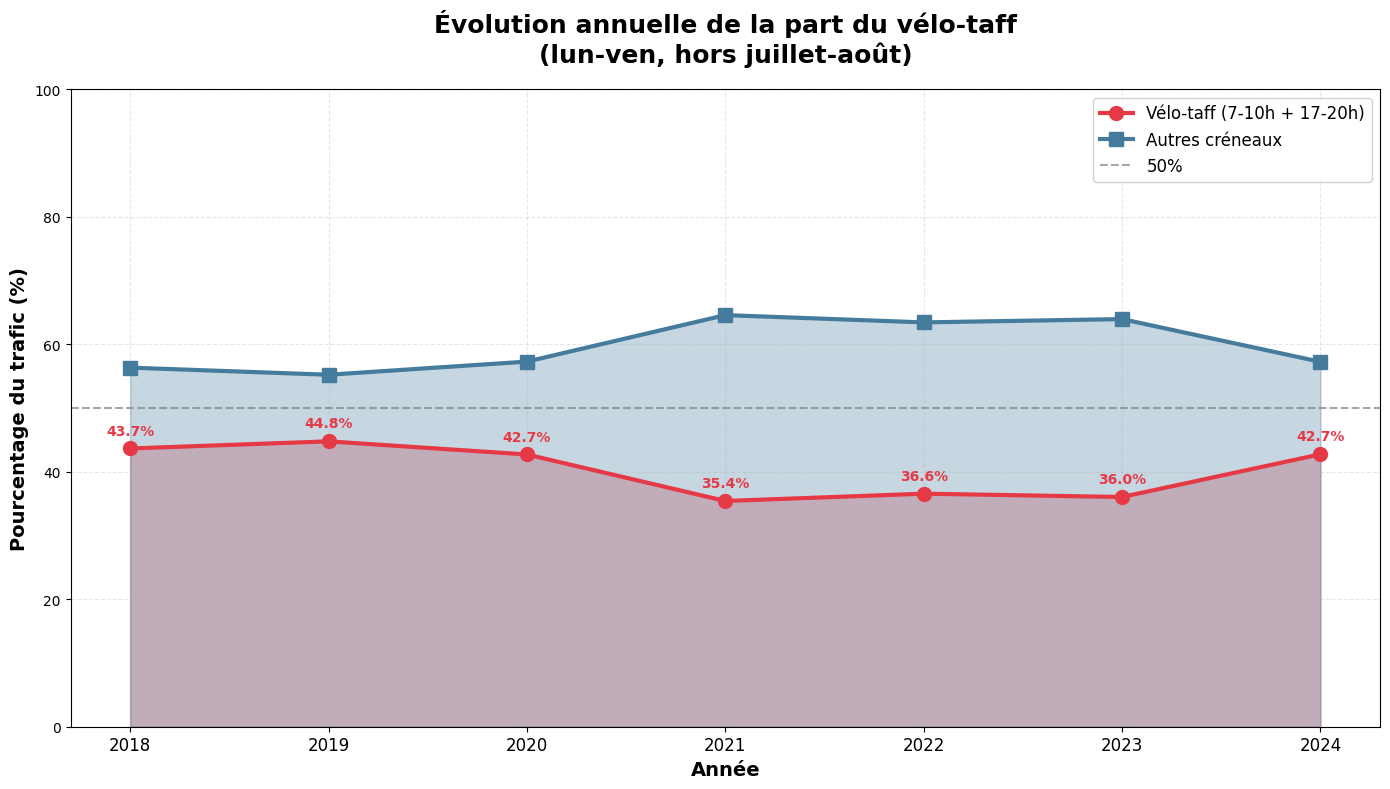


 Évolution détaillée par année :

Année          Vélo-taff          Autres           Total     % Taff
----------------------------------------------------------------------
2018           1,284,996       1,658,337       2,943,333      43.7%
2019           5,784,424       7,134,653      12,919,077      44.8%
2020          11,786,019      15,807,205      27,593,224      42.7%
2021          11,767,196      21,456,319      33,223,515      35.4%
2022          13,807,318      23,956,518      37,763,836      36.6%
2023          16,983,480      30,135,950      47,119,430      36.0%
2024          18,126,054      24,274,360      42,400,414      42.7%

Analyse vélo-taff terminée


In [12]:
pivot_creneaux = analyze_commute_traffic(df)
plot_commute_evolution(pivot_creneaux)

**Résultats :** la part du vélo-taff a diminué entre 2021 et 2023, puis est revenu au niveau de 2018 en 2024.

**Hypothèse :** baisse au moment du covid et après car télétravail, puis augmentation du fait de la généralisation du vélo comme mode de déplacement quotidien, et non pas seulement dédié au loisir, et un retour en présentiel voulu par les employeurs.

### Impact du télétravail sur les déplacements vélo

Comparaison du trafic vélo entre :
- **Lundi + Vendredi** (jours télétravaillés)
- **Mardi/Mercredi/Jeudi** (jours de présence au bureau)

Visualisation du ratio pour détecter l'évolution des habitudes de télétravail.


ANALYSE TÉLÉTRAVAIL : Lundi+Vendredi vs Mardi+Mercredi+Jeudi

Filtrage des données
  Lignes après filtrage : 3,139,237

Catégorisation des jours :
  • Début/Fin semaine : Lundi + Vendredi
  • Milieu semaine    : Mardi + Mercredi + Jeudi
  • Heures analysées  : 7-10h + 17-20h
  • Période           : Hors juillet-août

Résultats par année :

Année            Lun+Ven     Mar+Mer+Jeu   Ratio brut   Ratio/jour
----------------------------------------------------------------------
2018             489,065         795,931        0.614        0.922
2019           2,255,830       3,528,594        0.639        0.959
2020           4,396,418       7,389,601        0.595        0.892
2021           4,332,186       7,435,010        0.583        0.874
2022           4,987,499       8,819,819        0.565        0.848
2023           6,296,438      10,687,042        0.589        0.884
2024           6,738,130      11,387,924        0.592        0.888

Évolution du ratio par jour :
  2018 : 0.922
  20

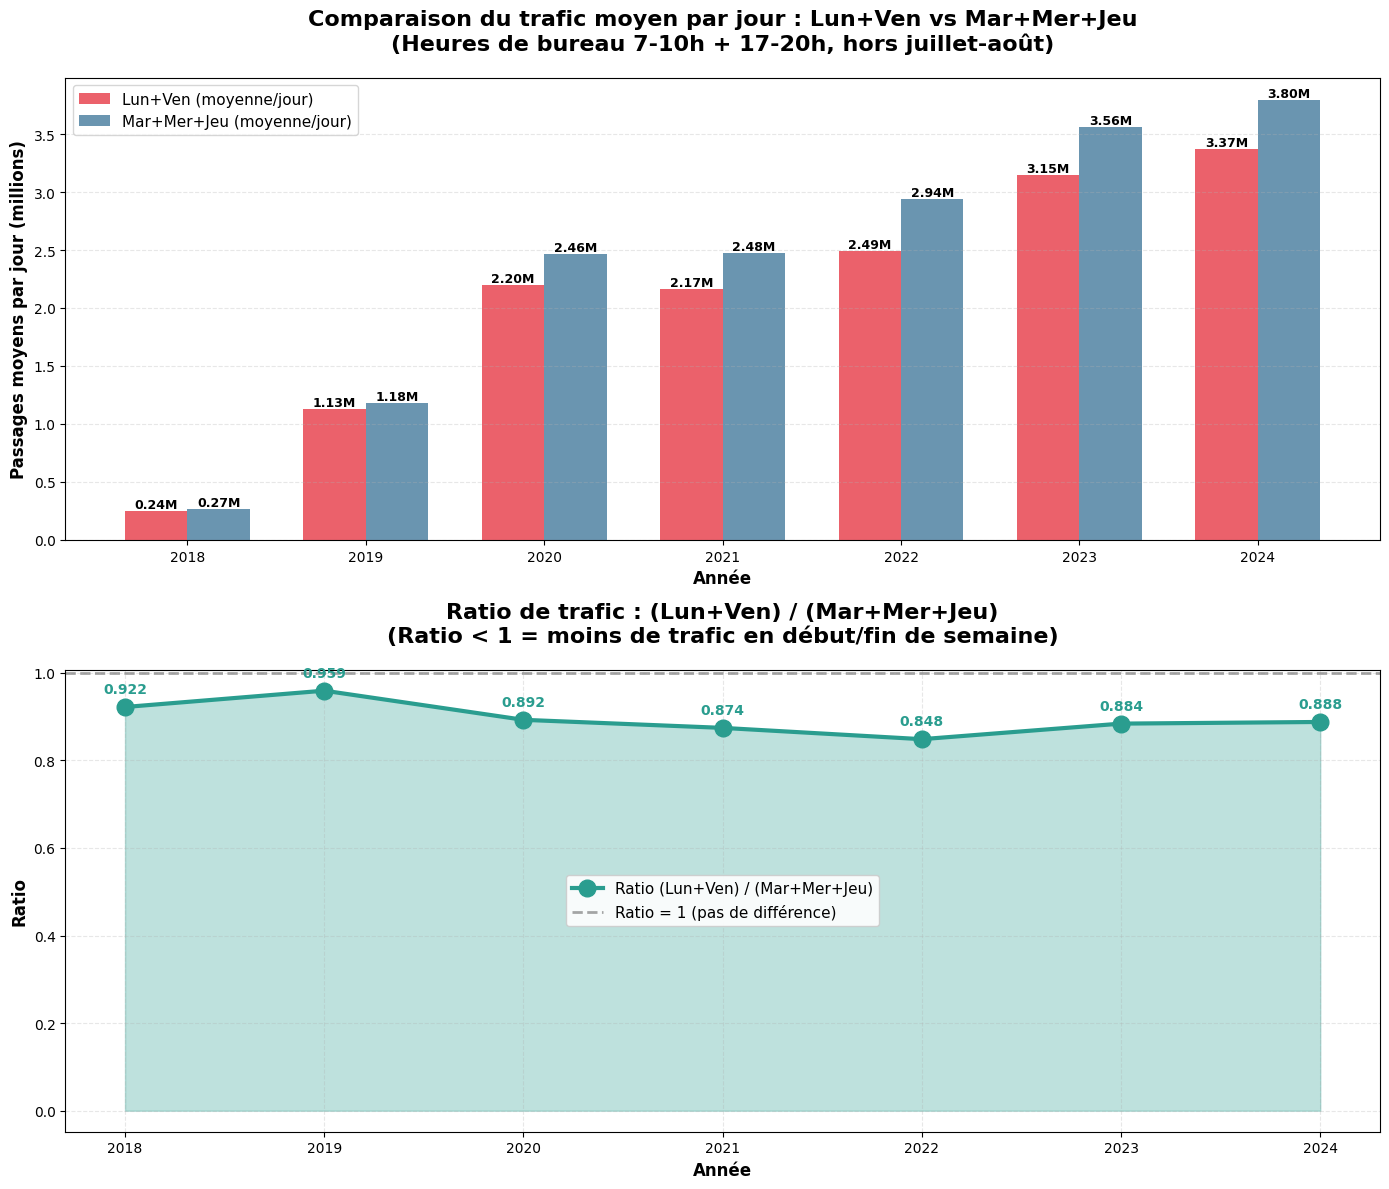


ANALYSE TÉLÉTRAVAIL TERMINÉE

 Interprétation :
  • Ratio > 1 : Plus de trafic le lun+ven que mar+mer+jeu
  • Ratio < 1 : Moins de trafic le lun+ven (effet télétravail ?)
  • Ratio qui baisse = augmentation du télétravail


In [13]:
pivot_jours = analyze_telework_effect(df)
plot_telework_analysis(pivot_jours)

**Hypothèse** : Le lundi et le vendredi sont davantage télétravaillés que les jours du milieu de semaine.


**Résultats** :

**Graphique barres** : Trafic absolu croissant pour les deux groupes de jours

**Graphique ratio** : Évolution de l'écart entre début/fin et milieu de semaine
- **2018-2019** : Ratio = 0.92-0.96 (légère baisse lun+ven, déjà présente)
- **2020** : Ratio = 0.89 (baisse accentuée pendant COVID)
- **2021-2022** : Ratio = 0.87-0.85 (creux, télétravail massif)
- **2023-2024** : Ratio = 0.88-0.89 (stabilisation)

**Interprétation** : Le ratio < 1 et en baisse post-COVID indique que le lundi et le vendredi sont davantage télétravaillés, donc l'hypothèse est valide.


**Conclusion** : Le télétravail a probablement modifié durablement les patterns hebdomadaires de déplacement à vélo, avec une concentration accrue sur les jours Mar-Mer-Jeu.

## Partie 2 : Collecte et description des données météorologiques 

### A) Collecte et manipulation des données vélo

Cette partie a pour but d'expliciter les étapes suivies pour la collecte des données météorologiques. Elle s'articule autour de trois sous-parties :
1) Importation et traitement des données de comptage de vélos par sites de comptage pour chaque année, 
2) Établissement d'une liste des sites de comptage par année avec l'arrondissement correspondant, 
3) Collecte des données météorologiques (température apparente, volume des précipitations, pourcentage de couverture nuageuse) pour chaque heure de l'année pour chaque site de comptage via l'API historique d'Open-Meteo

Sur VS-Code dans Onyxia-SSP cloud, les données de comptages de vélos par sites de comptages (du style AAAA_comptage-velo-donnees-sites-comptage.csv ou AAAA-comptage-velo-donnees-sites-comptage.csv pour 2023 et 2024) étaient stockées dans un dossier "données vélo", le chemin de lecture était donc indiqué par des expressions de la forme "données vélo/2018_comptage-velo-donnees-sites-comptage.csv". Les données acquises grâce à l'API du site Open-Meteo quant à elles étaient stockées dans un dossier "données météo" sous format "2018_2024_temperature_horaire_par_site_comptage.csv" par exemple, le chemin de lecture était donc indiqué par une expression du style "données météo/2018_2024_temperature_horaire_par_site_comptage.csv". 

#  ⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
Cet avertissement sera réitéré au début du A) 3) mais les trois premières cellules de cette sous-partie ne sont pas destinées à être exécutées (leur lecture prend plusieurs dizaines de minutes chacune, en outre elles risquent de ne pas fonctionner en journée du fait d'un trop grand nombre de demandes). Les fichiers csv de stockage de données obtenus via l'API historique du site Open-Meteo sont disponibles sur le google drive envoyé par mail. 

#### 1) Importation et traitement des données de comptage de vélos par sites de comptage pour chaque année


Étant donné que nous intéressons surtout aux noms des sites de comptage dans cette partie, (en l'occurrence ce sont par exemple les valeurs manquantes (NaN) pour les sites de comptage qui posent problème et non pas pour celles pour le comptage horaire, en outre, une autre méthode de lecture de fichiers, la méthode CSV, sera utilisé dans cette sous-partie).

In [ ]:
# Chargement des fichiers CSV de comptage de velos par sites de comptage des années 2018 à 2024 dans des Dataframes 
# puis visualisation des premières lignes, de la liste des colonnes et de la taille de chacun des fichiers.

annees = {
    2018: ("données vélo/2018_comptage-velo-donnees-sites-comptage.csv", ";"),
    2019: ("données vélo/2019_comptage-velo-donnees-sites-comptage.csv", ";"),
    2020: ("données vélo/2020_comptage-velo-donnees-sites-comptage.csv", ";"),
    2021: ("données vélo/2021_comptage-velo-donnees-sites-comptage.csv", ";"),
    2022: ("données vélo/2022_comptage-velo-donnees-sites-comptage.csv", ";"),
    2023: ("données vélo/2023-comptage-velo-donnees-sites-comptage.csv", ","),
    2024: ("données vélo/2024-comptage-velo-donnees-sites-comptage.csv", ";"),
}

dfs = {}

for annee, (fichier, sep) in annees.items():
    dfs[annee] = pd.read_csv(fichier, sep=sep, on_bad_lines="warn")
    print(f"Données de comptage en {annee} :")
    display(dfs[annee].head())
    print("Colonnes :", dfs[annee].columns)
    print("Taille :", dfs[annee].shape)


In [ ]:
# Cette cellule a pour objectif de concaténer les DataFrames contenant les données par sites de comptage des fichiers CSV des années 2018 à 2024. 
# À partir de 2021, il n'y a plus de colonne "Date d'installation du point de comptage", le DataFrame concaténé contiendra donc la valeur "None" pour les années où cette information est manquante. 
# Par ailleurs, pour plus de lisibilité, toutes les valeurs de la colonne "Date et heure de comptage" (certaines années indiquant un fuseau horaire avec +01:00 ou +02:00) sont converties ou maintenues en heure locale.

import pandas as pd

# Colonnes de référence
COLONNES_REF = [
    "Identifiant du point de comptage",
    "Nom du point de comptage",
    "Comptage horaire",
    "Date et heure de comptage",
    "Date d'installation du point de comptage",
    "Lien vers photo du point de comptage",
    "Coordonnées géographiques"
]

# Fonction : lecture + normalisation + conversion heure locale
def lire_normaliser_en_heure_locale(path, sep):
    df = pd.read_csv(path, sep=sep, on_bad_lines="warn")

    # Ajout colonne manquante "Date d'installation du point de comptage" si nécessaire (notamment à partir de 2021 )
    if "Date d'installation du point de comptage" not in df.columns:
        df["Date d'installation du point de comptage"] = pd.NA

    # Ajout des autres colonnes manquantes
    for col in COLONNES_REF:
        if col not in df.columns:
            df[col] = None

    # Gestion des dates
    dates_raw = df["Date et heure de comptage"].astype(str)
    mask_fuseau = dates_raw.str.contains(r"\+|-Z", regex=True)
    dt = pd.Series(index=df.index, dtype="datetime64[ns]")

    # Dates AVEC fuseau horaire
    dt.loc[mask_fuseau] = (
        pd.to_datetime(dates_raw[mask_fuseau], utc=True, errors="coerce")
        .dt.tz_convert("Europe/Paris")
        .dt.tz_localize(None)
    )

    # Dates SANS fuseau
    dt.loc[~mask_fuseau] = (
        pd.to_datetime(dates_raw[~mask_fuseau], errors="coerce")
        .dt.tz_localize("Europe/Paris", ambiguous="NaT", nonexistent="shift_forward")
        .dt.tz_localize(None)
    )

    df["Date et heure de comptage"] = dt
    return df[COLONNES_REF]

# Dictionnaire avec année : (chemin, séparateur)
fichiers = {
    2018: ("données vélo/2018_comptage-velo-donnees-sites-comptage.csv", ";"),
    2019: ("données vélo/2019_comptage-velo-donnees-sites-comptage.csv", ";"),
    2020: ("données vélo/2020_comptage-velo-donnees-sites-comptage.csv", ";"),
    2021: ("données vélo/2021_comptage-velo-donnees-sites-comptage.csv", ";"),
    2022: ("données vélo/2022_comptage-velo-donnees-sites-comptage.csv", ";"),
    2023: ("données vélo/2023-comptage-velo-donnees-sites-comptage.csv", ","),
    2024: ("données vélo/2024-comptage-velo-donnees-sites-comptage.csv", ";")
}

# Lecture + normalisation de tous les fichiers
dfs = {}
for annee, (path, sep) in fichiers.items():
    dfs[annee] = lire_normaliser_en_heure_locale(path, sep)

# Concaténation finale
df_2018_2024 = pd.concat(dfs.values(), ignore_index=True)

# Vérification
df_2018_2024.head()


In [ ]:
# Première vérification rapide concernant la concaténation des DataFrames (test d'égalité du nombre de lignes)

# Somme des lignes des DataFrames individuels
total_lignes_individuel = sum(len(df) for df in dfs.values())

# Nombre de lignes dans le DataFrame concaténé
total_lignes_concatene = len(df_2018_2024)

print("Nombre de lignes concaténées :", total_lignes_concatene)
print("Somme des lignes individuelles :", total_lignes_individuel)
print("Concaténation a priori correcte ?", total_lignes_concatene == total_lignes_individuel)

In [ ]:
# Visualation du nombre de valeurs potentiellement problématiques pour chaque colonne 
display(df_2018_2024.isna().sum()) 
display((df_2018_2024.isna().mean() * 100).round(2))


# Etant donné que la colonne date d'installation du point de comptage n'existe plus après 2021, il est probable qu'il y ait de très nombreuses cellules manquantes pour cette colonne 

In [ ]:
# Seconde vérification rapide concernant la concaténation des dataframes 
# (en comparant les valeurs manquantes dans le dataframe concaténé et la somme des valeurs manquantes dans les dataframes individuels pour les années 2018 à 2024)

#  Colonnes à vérifier

colonnes_a_tester = [
    "Nom du point de comptage",
    "Comptage horaire",
    "Date et heure de comptage",
    "Coordonnées géographiques"
]

# Nombre de valeurs manquantes dans le DataFrame concaténé
na_concatene = df_2018_2024[colonnes_a_tester].isna().sum()

# Nombre de valeurs manquantes dans l'ensemble des DataFrames individuels
na_individuels = (
    pd.concat([df[colonnes_a_tester] for df in dfs.values()])
    .isna()
    .sum()
)

# Comparaison des deux résultats
comparaison_na = pd.DataFrame({
    "Valeurs manquantes (concaténé)": na_concatene,
    "Valeurs manquantes (somme des DataFrames annuels)": na_individuels
})

# Colonne booléenne indiquant si les deux comptes sont identiques
comparaison_na["Égalité"] = (
    comparaison_na["Valeurs manquantes (concaténé)"]
    == comparaison_na["Valeurs manquantes (somme des DataFrames annuels)"]
)

# Affichage du tableau de comparaison
display(comparaison_na)


# Test global de cohérence
concat_ok = comparaison_na["Égalité"].all()

print(f"Concaténation a priori correcte ? {concat_ok}")

In [ ]:
# Le nombre de cellules manquantes pour les colonnes "Nom du point de comptage" et "Coordonnées géographiques" est très similaire (à une unité près sur plus de 22 millions de lignes !)
# Nous testons donc l'hypothèse selon laquelle si la cellule est manquante pour la colonne "Nom du point de comptage", alors elle sera également manquante pour la colonne "coordonnées géographiques"
mask_nom_manquant = df_2018_2024["Nom du point de comptage"].isna()
df_2018_2024.loc[mask_nom_manquant, "Coordonnées géographiques"].isna().value_counts()


In [ ]:
# Conversion des valeurs des coordonnées géographiques en nombres décimaux 
# (certaines sont affichées en écriture scientifique notamment pour 2023)

# Séparation temporaire (sans modification du DataFrame)
coords = df_2018_2024["Coordonnées géographiques"].astype(str).str.split(",", expand=True)

# Conversion numérique ()
lat = pd.to_numeric(coords[0], errors="coerce")
lon = pd.to_numeric(coords[1], errors="coerce")

# Reconstruction propre de la colonne "Coordonnées géographiques"
df_2018_2024["Coordonnées géographiques"] = (
    lat.astype(str)
       .where(lat.notna() & lon.notna(), pd.NA)
    + ","
    + lon.astype(str)
)


In [ ]:
# Verification que le nombre de cellules manquantes n'a pas changé
df_2018_2024.isna().sum()

In [ ]:
# Suppression des lignes pour lesquelles la cellule du nom de point de comtage est manquante
df_2018_2024 = df_2018_2024.dropna(subset=["Nom du point de comptage"])

In [ ]:
# Vérification que la suppression de cellules manquantes a bien été effectuée
df_2018_2024.isna().sum()

In [ ]:
# Suppression des colonnes inutiles (en l'occurence nous nous appuierons sur la colonne "Nom du point de comptage" pour identifier les différents sites de comptage,
#  donc la colonne "Identifiant du point de comptage" nous est ici inutile 
# tout comme les colonnes "Date d'installation du point de comptage","Lien vers photo du point de comptage" )

df_2018_2024 = df_2018_2024.drop(
    columns=["Identifiant du point de comptage", "Date d'installation du point de comptage","Lien vers photo du point de comptage"]
)
df_2018_2024.head()

In [ ]:
# Séparation latitude et longitude (cela sera utile pour la collecte des données météorologiques)
df_2018_2024[['latitude', 'longitude']] = df_2018_2024['Coordonnées géographiques'].str.split(',', n=1, expand=True)

df_2018_2024.head()

In [ ]:
# Classement des données par nom de point de comptage puis dans une fois qu'il est réalisé par date et heure de comptage croissante
df_2018_2024_sortedbyplace = df_2018_2024.sort_values(by=["Nom du point de comptage","Date et heure de comptage"])
df_2018_2024_sortedbyplace.head()

#### 2) Établissement d'une liste des sites de comptage par année avec l'arrondissement correspondant

Dans cette sous-partie, nous construirons trois tableaux : 
1) le premier (à partir de la fonction sites_par_annee) montrera la liste des noms de points de comptage apparaissant dans le fichier CSV de comptage de vélos par sites de comptage de chaque année avec les coordonnées géographiques, la longitude et la latitude correspondantes
2) le deuxième (à partir de la fonction ajouter_arrondissements) montrera la liste des noms de points de comptage apparaissant dans le fichier CSV de comptage de vélos par sites de comptage de chaque année avec aussi l'arrondissement correspondant en plus des coordonnées géographiques, de la longitude et de la latitude
3) le troisième (à partir de la fonction tableau_par_arrondissement) montrera pour chaque arrondissement les coordonnées des points de comptage qui y sont situés (cela servira après la collecte des données météorologiques pour la construction de graphiques)

In [ ]:
# Définition de la fonction qui retourne une liste unique de sites pour une année donnée
def sites_par_annee(df_all, annee):
    """
    Retourne un DataFrame avec 1 ligne par point de comptage
    présent l'année donnée.
    Si la colonne 'annee' n'existe pas, elle est créée automatiquement.
    """
    # Copie du DateFrame pour ne pas modifier l'original
    df = df_all.copy()

    # Création de la colonne 'annee' si elle n'existe pas
    if "annee" not in df.columns:
        df["annee"] = df["Date et heure de comptage"].dt.year

    # Filtrage pour l'année demandée
    df_year = df[df["annee"] == annee]

    cols = ["Nom du point de comptage", "Coordonnées géographiques", "latitude", "longitude"]
    
    # Elimination des doublons et classement par ordre alphabétique
    return (
        df_year[cols]
        .drop_duplicates(subset=["Nom du point de comptage"])
        .sort_values("Nom du point de comptage")
        .reset_index(drop=True)
    )


In [ ]:
# Attribution des arrondissements via une jointure spatiale

# Chargement de geopandas pour manipuler des données géographiques
import geopandas as gpd

# URL du GeoJSON des arrondissements de Paris (délimitation des polygones)
url_geojson = (
    "https://opendata.paris.fr/explore/dataset/arrondissements/"
    "download/?format=geojson&timezone=Europe/Berlin&lang=fr"
)

# Lecture du GeoJSON des arrondissements et projection en EPSG:4326 (lat/lon)
gdf_arr = gpd.read_file(url_geojson).to_crs(epsg=4326)  

# Définition de la fonction pour faire une jointure spatiale entre sites et arrondissements
def ajouter_arrondissements(df_sites, gdf_arr):
    """
    Ajoute la colonne 'arrondissement' à un DataFrame de sites.
    """

    # Copie du DataFrame des sites pour ne pas modifier l’original
    df = df_sites.copy()

    # Vérification que la latitude et la longitude sont des valeurs numériques 
    df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

    # Suppression des lignes sans coordonnées valides
    df = df.dropna(subset=["latitude", "longitude"])

    # Création d'un GeoDataFrame à partir des coordonnées (points)
    gdf_sites = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )

    # Jointure spatiale : pour chaque point, trouver l'arrondissement "within" (dans lequel il se trouve)
    gdf_joined = gpd.sjoin(
        gdf_sites,
        gdf_arr,
        how="left",
        predicate="within"
    )

    # Sélection des les colonnes utiles, tri les résultats et réinitialisation l’index
    return (
        gdf_joined[
            [
                "Nom du point de comptage",           
                "Coordonnées géographiques",         
                "latitude",                           
                "longitude",                          
                "l_ar"                                
            ]
        ]
        .rename(columns={"l_ar": "arrondissement"})      
        .sort_values("Nom du point de comptage")          
        .reset_index(drop=True)                           
    )


In [ ]:
# Mise au point d'un tableau avec par arrondissement les coordonnées géographiques, la latitude, la longitude
def tableau_par_arrondissement(df_final):

    # Fonction interne pour convertir une liste en chaîne séparée par des points‑virgules
    def list_to_semicolon_str(x):
        return "; ".join(str(v) for v in x if pd.notna(v))

    # Regroupement de toutes les lignes du DateFrame qui appartiennent au même arrondissement 
    tableau = (
        df_final
        .groupby("arrondissement", dropna=False)  
        .agg({
            "Coordonnées géographiques": list_to_semicolon_str,  
            "latitude": list_to_semicolon_str,                    
            "longitude": list_to_semicolon_str                    
        })
        .reset_index()  
    )

    # Extraction numérique du numéro d'arrondissement pour ensuite les trier dans l'ordre croissant
    tableau["arr_num"] = (
        tableau["arrondissement"]
        .str.extract(r"(\d+)", expand=False)  
        .astype(float, errors="ignore")       
    )

    # Retour du tableau trié par nom d’arrondissement 
    return (
        tableau
        .sort_values("arr_num", na_position="last")  
        .drop(columns="arr_num")                     
        .reset_index(drop=True)                      
    )


In [ ]:
#Affichage des trois tableaux pour chaque année 

# Affichage complet : toutes les lignes et toutes les colonnes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

annees = range(2018, 2025)  # de 2018 à 2024 inclus

for annee in annees:
    print(f"\n Tableaux pour l'année {annee}\n")
    
    #  DataFrames des sites pour l'année
    df_sites = sites_par_annee(df_2018_2024, annee)
    print(f"Liste des noms des points de comptage avec les coordonnées géographiques, la latitude, la longitude correspondantes pour {annee} :")
    display(df_sites)
    
    # Ajout des arrondissements
    df_final = ajouter_arrondissements(df_sites, gdf_arr)
    print(f"Liste des noms des points de comptage avec les arrondissements correspondants en plus des coordonnées géographiques, de la latitude, de la longitude, pour {annee} :")
    display(df_final)
    
    # Tableau par arrondissement
    tableau_arr = tableau_par_arrondissement(df_final)
    print(f"Tableau par arrondissement des coordonnées géographiques, la latitude, la longitude des points de comptage qui y sont situés pour {annee} :")
    display(tableau_arr)

# NB. : Le point de comptage situé face au 40 Quai d'Issy est techniquement situé à l'extérieur du Boulevard périphérique et appartient à la commune d'Issy-les-Moulineaux, il est donc normal qu'aucun arrondissement correspondant ne s'affiche (à la place la cellule pour la colonne arrondissement affiche NaN )

#### 3) Collecte des données météorologiques (température apparente, volume des précipitations, pourcentage de couverture nuageuse) pour chaque heure de l'année pour chaque site de comptage via l'API historique d'Open-Meteo

Cette sous-partie a pour but de montrer comment nous sommes parvenus à collecter de 2018 à 2024, pour chaque heure de l'année, la température apparente en degrés celsius (température apparente qui dépend également de la force du vent, des radiations solaires et de l'humidité), les volumes de précipitations en mm, la couverture nuageuse en pourcentage pour chaque site de comptage.
Nous avons choisi ces trois indicateurs car ils nous paraissaient à première vue comme ceux qui pouvaient avoir le plus d'impact sur la circulation en vélos.
Nous avons collecté nos données sur le site open-meteo.com (https://open‑meteo.com) (données sous licence CC B.Y 4.0, c'est-à-dire librement copiables, redistribuables, réutilisables et modifiables si attribution appropriée).
Nous nous sommes aussi basé sur les acquis de la sous-partie précédente (notamment pour avoir la liste des noms de points de comptage, leur coordonnées géographiques, leur longitude, leur latitude pour chaque année).

#  ⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
Les trois premières cellules de cette sous-partie ne sont pas destinées à être exécutées (leur lecture prend plusieurs dizaines de minutes chacune, en outre elles risquent de ne pas fonctionner en journée du fait d'un trop grand nombre de demandes). Elles détaillent la manière dont les fichiers csv qui renseignent sur la température apparente, les volumes de précipitations et la couverture nuageuse par site de comptage pour chaque heure de chaque année ont été obtenus. Ces fichiers sont consultables sur le google drive envoyé par mail. 

In [ ]:
#  ⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
# Ne pas exécuter ce code (cela prend plusieurs dizaines de minutes, et il peut ne pas marcher en journée lorsque l'API du site est submergé de demandes)

import requests
import pandas as pd
import os
import time

# Préparation des sites avec arrondissements

df_sites_final = df_2018_2024.merge(
    df_2018_final[['Nom du point de comptage', 'arrondissement']],
    on='Nom du point de comptage',
    how='left'
)

# S’assurer que latitude/longitude sont numériques
df_sites_final['latitude'] = pd.to_numeric(df_sites_final['latitude'], errors='coerce')
df_sites_final['longitude'] = pd.to_numeric(df_sites_final['longitude'], errors='coerce')

#  Ajout de la colonne 'annee' si elle n’existe pas déjà
#   On l’extrait de la colonne "Date et heure de comptage" pour permettre le filtrage par année.
if "annee" not in df_sites_final.columns:
    df_sites_final["annee"] = pd.to_datetime(
        df_sites_final["Date et heure de comptage"],
        errors="coerce"
    ).dt.year

# Paramètres généraux pour l'API

YEARS = range(2018, 2025)  # 2018 → 2024
results_temp = []
DELAY_BETWEEN_REQUESTS = 1.0  # en secondes

# Dossier de sauvegarde
output_dir = "données météo"
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "2018_2024_temperature_horaire_par_site_comptage.csv")

# Boucle sur les années

for annee in YEARS:
    print(f"\n📅 Traitement de l'année {annee}")
    start_date = f"{annee}-01-01"
    end_date   = f"{annee}-12-31"

    # Filtrer les sites présents pour cette année
    df_sites_year = (
        df_sites_final[df_sites_final["annee"] == annee]
        [["Nom du point de comptage", "arrondissement", "latitude", "longitude"]]
        .drop_duplicates(subset=["Nom du point de comptage"])
        .dropna(subset=["latitude", "longitude"])
        .reset_index(drop=True)
    )

    print(f"➡️ {len(df_sites_year)} sites à traiter")

    # Boucle sur les sites de l’année
    for _, row in df_sites_year.iterrows():
        nom_site = row["Nom du point de comptage"]
        arr      = row["arrondissement"]
        lat      = float(row["latitude"])
        lon      = float(row["longitude"])

        print(f"   📡 {nom_site}")

        try:
            # URL d’appel à l’API Open‑Meteo pour les données historiques
            url = (
                "https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}"
                f"&start_date={start_date}&end_date={end_date}"
                "&hourly=apparent_temperature"
                "&timezone=Europe/Paris"
            )

            resp = requests.get(url, timeout=30)
            resp.raise_for_status()
            data = resp.json()

            if "hourly" not in data:
                continue

            heures = data["hourly"].get("time", [])
            temps  = data["hourly"].get("apparent_temperature", [])

            # Ajout des lignes pour chaque heure dans la liste results_temp
            for dt, temp in zip(heures, temps):
                results_temp.append({
                    "nom_point_comptage": nom_site,
                    "arrondissement": arr,
                    "latitude": lat,
                    "longitude": lon,
                    "datetime": dt,
                    "temperature_apparente": temp
                })

        except Exception as e:
            print(f"❌ Erreur pour {nom_site} ({lat},{lon}) : {e}")

        # Pause entre les requêtes pour ne pas saturer l’API
        time.sleep(DELAY_BETWEEN_REQUESTS)


# Création du DataFrame final

df_temp_horaire = pd.DataFrame(results_temp)

# Conversion de "datetime" en format datetime
df_temp_horaire["datetime"] = pd.to_datetime(
    df_temp_horaire["datetime"],
    errors="coerce"
)

# Tri chronologique : année → nom de point → datetime
df_temp_horaire["annee"] = df_temp_horaire["datetime"].dt.year
df_temp_horaire = df_temp_horaire.sort_values(
    by=["annee", "nom_point_comptage", "datetime"]
).reset_index(drop=True)

# Suppression de la colonne temporaire "annee"
df_temp_horaire = df_temp_horaire.drop(columns=["annee"])

# Sauvegarde locale du fichier CSV

df_temp_horaire.to_csv(csv_path, index=False)
print(f"\n✅ Données sauvegardées dans {csv_path}")

# Aperçu du résultat

with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df_temp_horaire.head(5))


In [ ]:
#  ⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
# Ne pas exécuter ce code (cela prend plusieurs dizaines de minutes, et il peut ne pas marcher en journée lorsque l'API du site est submergé de demandes)

import requests
import pandas as pd
import os
import time

# Préparation des sites avec arrondissements

df_sites_final = df_2018_2024.merge(
    df_2018_final[['Nom du point de comptage', 'arrondissement']],
    on='Nom du point de comptage',
    how='left'
)

df_sites_final['latitude'] = pd.to_numeric(df_sites_final['latitude'], errors='coerce')
df_sites_final['longitude'] = pd.to_numeric(df_sites_final['longitude'], errors='coerce')

#  Ajout de la colonne 'annee' si elle n’existe pas déjà
#   On l’extrait de la colonne "Date et heure de comptage" pour permettre le filtrage par année.
if "annee" not in df_sites_final.columns:
    df_sites_final["annee"] = pd.to_datetime(
        df_sites_final["Date et heure de comptage"],
        errors="coerce"
    ).dt.year
 
# Paramètres généraux pour l'API

YEARS = range(2018, 2025)  # 2018 → 2024
results_precip = []
DELAY_BETWEEN_REQUESTS = 1.0  # en secondes

output_dir = "données météo"
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "2018_2024_precipitation_horaire_par_site_comptage.csv")

# Boucle sur les années

for annee in YEARS:
    print(f"\n📅 Traitement de l'année {annee}")
    start_date = f"{annee}-01-01"
    end_date   = f"{annee}-12-31"

    df_sites_year = (
        df_sites_final[df_sites_final["annee"] == annee]
        [["Nom du point de comptage", "arrondissement", "latitude", "longitude"]]
        .drop_duplicates(subset=["Nom du point de comptage"])
        .dropna(subset=["latitude", "longitude"])
        .reset_index(drop=True)
    )

    print(f"➡️ {len(df_sites_year)} sites à traiter")

    for _, row in df_sites_year.iterrows():
        nom_site = row["Nom du point de comptage"]
        arr      = row["arrondissement"]
        lat      = float(row["latitude"])
        lon      = float(row["longitude"])

        print(f"   🌧️ {nom_site}")

        try:
            url = (
                "https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}"
                f"&start_date={start_date}&end_date={end_date}"
                "&hourly=precipitation"
                "&timezone=Europe/Paris"
            )

            resp = requests.get(url, timeout=30)
            resp.raise_for_status()
            data = resp.json()

            if "hourly" not in data:
                continue

            heures = data["hourly"].get("time", [])
            prec   = data["hourly"].get("precipitation", [])

            for dt, p in zip(heures, prec):
                results_precip.append({
                    "nom_point_comptage": nom_site,
                    "arrondissement": arr,
                    "latitude": lat,
                    "longitude": lon,
                    "datetime": dt,
                    "precipitation_mm": p
                })

        except Exception as e:
            print(f"❌ Erreur pour {nom_site} ({lat},{lon}) : {e}")

        time.sleep(DELAY_BETWEEN_REQUESTS)

#  DataFrame final

df_precip_horaire = pd.DataFrame(results_precip)

# Conversion en datetime
df_precip_horaire["datetime"] = pd.to_datetime(
    df_precip_horaire["datetime"], errors="coerce"
)

# Ajout temporaire d'une colonne 'annee' pour trier
df_precip_horaire["annee"] = df_precip_horaire["datetime"].dt.year

# Tri par année, puis par nom de point, puis par datetime
df_precip_horaire = df_precip_horaire.sort_values(
    by=["annee", "nom_point_comptage", "datetime"]
).reset_index(drop=True)

# Suppression de la colonne `annee` avant sauvegarde
df_precip_horaire = df_precip_horaire.drop(columns=["annee"])

#  Sauvegarde locale

df_precip_horaire.to_csv(csv_path, index=False)
print(f"\n✅ Données sauvegardées dans {csv_path}")

#  Aperçu

with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df_precip_horaire.head(5))


In [ ]:
#  ⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
# Ne pas exécuter ce code (cela prend plusieurs dizaines de minutes, et il peut ne pas marcher en journée lorsque l'API du site est submergé de demandes)

import requests
import pandas as pd
import os
import time

# Préparation des sites avec arrondissements

df_sites_final = df_2018_2024.merge(
    df_2018_final[['Nom du point de comptage', 'arrondissement']],
    on='Nom du point de comptage',
    how='left'
)

df_sites_final['latitude'] = pd.to_numeric(df_sites_final['latitude'], errors='coerce')
df_sites_final['longitude'] = pd.to_numeric(df_sites_final['longitude'], errors='coerce')

#  Ajout de la colonne 'annee' si elle n’existe pas déjà
#   On l’extrait de la colonne "Date et heure de comptage" pour permettre le filtrage par année.
if "annee" not in df_sites_final.columns:
    df_sites_final["annee"] = pd.to_datetime(
        df_sites_final["Date et heure de comptage"],
        errors="coerce"
    ).dt.year

# Paramètres généraux pour l'API

YEARS = range(2018, 2025)  # 2018 → 2024
results_cloud = []
DELAY_BETWEEN_REQUESTS = 1.0  # en secondes

output_dir = "données météo"
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "2018_2024_cloudcover_horaire_par_site_comptage.csv")

# Boucle sur les années

for annee in YEARS:
    print(f"\n📅 Traitement de l'année {annee}")
    start_date = f"{annee}-01-01"
    end_date   = f"{annee}-12-31"

    df_sites_year = (
        df_sites_final[df_sites_final["annee"] == annee]
        [["Nom du point de comptage", "arrondissement", "latitude", "longitude"]]
        .drop_duplicates(subset=["Nom du point de comptage"])
        .dropna(subset=["latitude", "longitude"])
        .reset_index(drop=True)
    )

    print(f"➡️ {len(df_sites_year)} sites à traiter")

    for _, row in df_sites_year.iterrows():
        nom_site = row["Nom du point de comptage"]
        arr      = row["arrondissement"]
        lat      = float(row["latitude"])
        lon      = float(row["longitude"])

        print(f"   ☁️ {nom_site}")

        try:
            url = (
                "https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}"
                f"&start_date={start_date}&end_date={end_date}"
                "&hourly=cloudcover"
                "&timezone=Europe/Paris"
            )

            resp = requests.get(url, timeout=30)
            resp.raise_for_status()
            data = resp.json()

            if "hourly" not in data:
                continue

            heures = data["hourly"].get("time", [])
            clouds = data["hourly"].get("cloudcover", [])

            for dt, c in zip(heures, clouds):
                results_cloud.append({
                    "nom_point_comptage": nom_site,
                    "arrondissement": arr,
                    "latitude": lat,
                    "longitude": lon,
                    "datetime": dt,
                    "cloudcover_pct": c
                })

        except Exception as e:
            print(f"❌ Erreur pour {nom_site} ({lat},{lon}) : {e}")

        time.sleep(DELAY_BETWEEN_REQUESTS)

# DataFrame final

df_cloudcover_horaire = pd.DataFrame(results_cloud)

# Conversion en datetime
df_cloudcover_horaire["datetime"] = pd.to_datetime(
    df_cloudcover_horaire["datetime"], errors="coerce"
)

# Ajout temporaire d'une colonne 'annee' pour trier
df_cloudcover_horaire["annee"] = df_cloudcover_horaire["datetime"].dt.year

# Tri : année → nom de point → datetime
df_cloudcover_horaire = df_cloudcover_horaire.sort_values(
    by=["annee", "nom_point_comptage", "datetime"]
).reset_index(drop=True)

# Suppression de la colonne temporaire
df_cloudcover_horaire = df_cloudcover_horaire.drop(columns=["annee"])

# Sauvegarde locale

df_cloudcover_horaire.to_csv(csv_path, index=False)
print(f"\n✅ Données sauvegardées dans {csv_path}")

# Aperçu

with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df_cloudcover_horaire.head(5))


⏰⚠️⚠️⚠️ WATCH OUT! ⚠️⚠️⚠️⏰
Pour l'exécution de la cellule suivante, le chemin d'accès aux fichiers "2018_2024_cloudcover_horaire_par_site_comptage.csv", "2018_2024_temperature_horaire_par_site_comptage.csv", 
"2018_2024_precipitation_horaire_par_site_comptage.csv",
joue aussi un rôle primordial. Sur notre espace de travail, ils était stockés dans "donnés météo" (d'où csv_path="données météo") 

In [ ]:
import pandas as pd
import os

# Fonction de vérification

def verifier_lignes_csv(csv_file, datetime_col, site_col, df_sites_cfg=None):
    """
    Vérifie par année : nb_lignes == nb_sites * 24 * nb_jours
    """

    df = pd.read_csv(csv_file)
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")

    df["annee"] = df[datetime_col].dt.year
    resultat = {}

    for annee, df_annee in df.groupby("annee"):
        # Nombre de sites
        if df_sites_cfg:
            df_sites, date_col, site_col_sites = df_sites_cfg
            nb_sites = (
                df_sites[df_sites[date_col].dt.year == annee]
                [site_col_sites]
                .nunique()
            )
        else:
            nb_sites = df_annee[site_col].nunique()

        # Nombre de jours dans l'année
        nb_jours = 366 if pd.Timestamp(annee, 12, 31).is_leap_year else 365

        nb_attendu = nb_sites * 24 * nb_jours
        nb_reel = len(df_annee)

        resultat[annee] = {
            "nb_sites": nb_sites,
            "nb_reel": nb_reel,
            "nb_attendu": nb_attendu,
            "egal": nb_reel == nb_attendu
        }

    return resultat


# Configuration des fichiers (ordre modifié)

csv_path = "données météo"

fichiers = {
    "Température": {
        "file": "2018_2024_temperature_horaire_par_site_comptage.csv",
        "datetime_col": "datetime",
        "site_col": None,
        "df_sites_cfg": (df_2018_2024, "Date et heure de comptage", "Nom du point de comptage")
    },
    "Précipitations": {
        "file": "2018_2024_precipitation_horaire_par_site_comptage.csv",
        "datetime_col": "datetime",
        "site_col": "nom_point_comptage",
        "df_sites_cfg": None
    },
    "Cloud cover": {
        "file": "2018_2024_cloudcover_horaire_par_site_comptage.csv",
        "datetime_col": "datetime",
        "site_col": None,
        "df_sites_cfg": (df_2018_2024, "Date et heure de comptage", "Nom du point de comptage")
    }
}

# Exécution

for nom, cfg in fichiers.items():
    print(f"\n📊 Vérifications – {nom}")

    res = verifier_lignes_csv(
        csv_file=os.path.join(csv_path, cfg["file"]),
        datetime_col=cfg["datetime_col"],
        site_col=cfg["site_col"],
        df_sites_cfg=cfg["df_sites_cfg"]
    )

    for annee, val in sorted(res.items()):
        status = "✅" if val["egal"] else "❌"
        print(
            f"Année {annee} (sites={val['nb_sites']}): "
            f"réel = {val['nb_reel']}, attendu = {val['nb_attendu']} {status}"
        )


Cette étape de vérification a permis de montrer que la collecte pour l'ensemble des sites pour chaque heure de chaque année semble s'être passée sans encombre en ce qui concerne la température apparente et les volumes de précipitation. 
En revanche, le nombre de lignes ne correspond exactement en ce qui concerne la couverture nuageuse. 
L'écart est toutefois très faible (en proportion) car il correspond à un problème de collecte pour chaque heure de l'année pour un seul site en 2018 et un autre en 2021.
La collecte des données s'est donc en apparence globalement bien passée.

### B) Analyse des données météorologiques 

Cette partie a pour objectif de montrer quelques statistiques descriptives concernant la température apparente, les volumes de précipitations, et la couverture nuageuse. 
Étant donné qu'il est impossible de modéliser l'évolution de ces trois variables pour chaque site de comptage, nous avons pris le partie de la modéliser par arrondissements.
Cette partie montrera trois graphes 
1) un montrant l'évolution de la moyenne mensuelle de la température apparente par arrondissement de 2018 à 2024
2) un autre montrant l'évolution de la moyenne mensuelle des volumes de précipitation par arrondissement de 2018 à 2024
3) un autre montrant l'évolution de la moyenne mensuelle de la couverture nuageuse par arrondissement de 2018 à 2024

In [ ]:
# Vérification du nombre de cellules manquantes sur les nouveaux fichiers csv
import pandas as pd

csv_file_temperature = "données météo/2018_2024_temperature_horaire_par_site_comptage.csv"
csv_file_precipitation = "données météo/2018_2024_precipitation_horaire_par_site_comptage.csv"
csv_file_cloudcover = "données météo/2018_2024_cloudcover_horaire_par_site_comptage.csv"

# Lecture des CSV
df_temperature = pd.read_csv(csv_file_temperature)
df_precipitation = pd.read_csv(csv_file_precipitation)
df_cloudcover = pd.read_csv(csv_file_temperature)

# Comptabilisation des valeurs manquantes par colonne pour chaque CSV
display(df_temperature.isna().sum())
display(df_precipitation.isna().sum())
display(df_cloudcover.isna().sum())

In [ ]:
# Attribution de l'arrondissement correspondant pour les lignes où la valeur est manquante

import pandas as pd
import geopandas as gpd

# Fichiers CSV

csv_temperature = "données météo/2018_2024_temperature_horaire_par_site_comptage.csv"
csv_precipitation = "données météo/2018_2024_precipitation_horaire_par_site_comptage.csv"
csv_cloudcover = "données météo/2018_2024_cloudcover_horaire_par_site_comptage.csv"

# Lecture des CSV

df_temp = pd.read_csv(csv_temperature)
df_precip = pd.read_csv(csv_precipitation)
df_cloud = pd.read_csv(csv_cloudcover)

# Conversion de la colonne datetime
for df in [df_temp, df_precip, df_cloud]:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Jointure spatiale pour remplir les arrondissements manquants

url_geojson = (
    "https://opendata.paris.fr/explore/dataset/arrondissements/"
    "download/?format=geojson&timezone=Europe/Berlin&lang=fr"
)
gdf_arr = gpd.read_file(url_geojson).to_crs(epsg=4326)

# Définition d'une fonction de remplissage des arrondissements manquants
def remplir_arrondissement(df):
    """
    Remplit les arrondissements manquants dans un DataFrame via jointure spatiale.
    """
    df_missing = df[df["arrondissement"].isna()]
    if df_missing.empty:
        return df

    gdf_points = gpd.GeoDataFrame(
        df_missing,
        geometry=gpd.points_from_xy(df_missing.longitude, df_missing.latitude),
        crs="EPSG:4326"
    )

    gdf_joined = gpd.sjoin(gdf_points, gdf_arr, how="left", predicate="within")

    # Remplissage valeurs manquantes
    df.loc[df["arrondissement"].isna(), "arrondissement"] = gdf_joined["l_ar"].values
    return df

# Application de la fonction aux trois DataFrames

df_temp = remplir_arrondissement(df_temp)
df_precip = remplir_arrondissement(df_precip)
df_cloud = remplir_arrondissement(df_cloud)




In [ ]:
# Vérification rapide du nombre d'arrondissements toujours manquants

print("Valeurs manquantes après remplissage :")
print("Temperature :", df_temp["arrondissement"].isna().sum())
print("Precipitation :", df_precip["arrondissement"].isna().sum())
print("Cloudcover :", df_cloud["arrondissement"].isna().sum())

La valeur de 61368 apparaît cohérente. En effet, le site de comptage situé face au 40 Quai d'Issy n'est pas stricto sensu dans Paris (cf. A) 2)) donc il est normal qu'il n'ait pas d'arrondissement attribué. Étant donné qu'il y a 2557 jours de 2018 à 2024 et que ce site de comptage apparaît sur tous les fichiers csv originaires de comptage de vélos il y a bien 2557 x 24 = 61368 valeurs manquantes pour chacune des trois variables. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#  Utilisation du DataFrame avec les arrondissements non manquants : df_temp

df_temp["annee_mois"] = df_temp["datetime"].dt.to_period("M")

# Calcul de la moyenne mensuelle de température par arrondissement
df_mensuel = (
    df_temp.groupby(["arrondissement", "annee_mois"], dropna=False)
           .agg(moyenne_temp_apparente=("temperature_apparente", "mean"))
           .reset_index()
)

# Conversion annee_mois en string pour affichage + tri
df_mensuel["annee_mois"] = df_mensuel["annee_mois"].astype(str)
df_mensuel = df_mensuel.sort_values(by=["arrondissement", "annee_mois"]).reset_index(drop=True)

print(df_mensuel.head())

# Pivot pour graphique : index = mois, colonnes = arrondissement
df_plot = df_mensuel.pivot(index="annee_mois", columns="arrondissement", values="moyenne_temp_apparente")

# Tracé
plt.figure(figsize=(16, 10))
for arr in df_plot.columns:
    plt.plot(df_plot.index, df_plot[arr], label=arr)

plt.title("Évolution mensuelle de la température apparente par arrondissement (2018 à 2024)")
plt.xlabel("Année-Mois")
plt.ylabel("Température apparente moyenne (°C)")
plt.xticks(rotation=45)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


Ce graphe montre que les différences de température entre les arrondissements sont minimes. 
De manière simplificatrice et a posteriori il est possible de dire qu'un seul arrondissement, voire un seul point auraient suffit pour tracer l'évolution de la température apparente à Paris de 2018 à 2024. 
Néanmoins, il aurait été peut-être imprudent (et contre-intuitif) de partir
avec cette hypothèse de départ. 
En outre, cette granularité des données nous sera peut-être utile dans la construction de notre modèle statistique


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Utilisation du DataFrame avec les arrondissements non manquants : df_precip

df_precip["annee_mois"] = df_precip["datetime"].dt.to_period("M")

# Calcul de la moyenne mensuelle des volumes de précipitations par arrondissement
df_mensuel = (
    df_precip.groupby(["arrondissement", "annee_mois"], dropna=False)
             .agg(moyenne_precip_mm=("precipitation_mm", "mean"))
             .reset_index()
)

# Conversion annee_mois en string pour affichage + tri
df_mensuel["annee_mois"] = df_mensuel["annee_mois"].astype(str)
df_mensuel = df_mensuel.sort_values(by=["arrondissement", "annee_mois"]).reset_index(drop=True)

print(df_mensuel.head())

# Pivot pour graphique : index = mois, colonnes = arrondissement
df_plot = df_mensuel.pivot(index="annee_mois", columns="arrondissement", values="moyenne_precip_mm")

# Tracé
plt.figure(figsize=(16, 10))
for arr in df_plot.columns:
    plt.plot(df_plot.index, df_plot[arr], label=arr)

plt.title("Évolution mensuelle de la précipitation moyenne par arrondissement (2018 à 2024)")
plt.xlabel("Année-Mois")
plt.ylabel("Précipitation moyenne (mm)")
plt.xticks(rotation=45)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


A la différence des moyennes mensuelles de températures par arrondissement qui variaient très peu, il semble y avoir de légères différences entre arrondissements (il n'y a pas une ligne d'une seule couleur qui écrase toutes les autres).
Cette observation a une certaine validité "empirique" (il est possible qu'il pleuve dans un arrondissement parisien et pas dans un autre).
Nous verrons lors de la construction du modèle statistique, quel est l'impact de cette relative disparité sur la circulation de vélos.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Utilisation du DataFrame avec les arrondissements non manquants : df_cloud

df_cloud["annee_mois"] = df_cloud["datetime"].dt.to_period("M")

# Calcul de la moyenne mensuelle de cloudcover par arrondissement
df_mensuel = (
    df_cloud.groupby(["arrondissement", "annee_mois"], dropna=False)
            .agg(moyenne_cloud_cover_pct=("cloudcover_pct", "mean"))
            .reset_index()
)

# Conversion annee_mois en string pour affichage + tri
df_mensuel["annee_mois"] = df_mensuel["annee_mois"].astype(str)
df_mensuel = df_mensuel.sort_values(by=["arrondissement", "annee_mois"]).reset_index(drop=True)

print(df_mensuel.head())

# Pivot pour graphique : index = mois, colonnes = arrondissement
df_plot = df_mensuel.pivot(index="annee_mois", columns="arrondissement", values="moyenne_cloud_cover_pct")

# Tracé
plt.figure(figsize=(16, 10))
for arr in df_plot.columns:
    plt.plot(df_plot.index, df_plot[arr], label=arr)

plt.title("Évolution mensuelle de la couverture nuageuse moyenne par arrondissement (2018–2024)")
plt.xlabel("Année-Mois")
plt.ylabel("Couverture nuageuse moyenne (%)")
plt.xticks(rotation=45)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


Comme pour la température apparente, il y a très peu de différences entre les arrondissements pour la couverture nuageuse mensuelle moyenne.

**Conclusion :** En nous appuyant sur les données de comptage de vélos par sites de comptage nous sommes parvenus à identifier, pour chaque année, la liste des sites de comptage avec leur arrondissement correspondant. Par la suite nous avons collecté les données météorologiques de ces trois variables via l'API historique du site Open-Meteo, pour chaque heure de l'année, pour chaque site de comptage. La visualisation des courbes d'évolution de ces trois variables a permis de montrer que les différences entre les arrondissements étaient faibles, à l'exception des moyennes mensuelles des volumes de précipitations. La granularité des données pourrait néanmoins s'avérer utile lors de la régression linéaire.

## Partie 3 : Régression log-niveau pour quantifier l'impact météo sur trafic vélo

**Objectif** : Quantifier l'effet de la météo sur les déplacements vélo à Paris (2021-2024)

**Données** :
- 9 compteurs périphériques (1 par arrondissement)
- Heures : 7h-22h
- Météo localisée par compteur

**Modèle** : log(passages) = f(température, pluie, nuages, weekend, heures, mois)

**Variables de contrôle** : Heures de la journée, mois, weekend

**Résultats** : 4 graphiques de validation + coefficients en %
- Température, précipitation, nuages, weekend
- R² = qualité du modèle

RÉGRESSION LOG-NIVEAU : IMPACT DE LA MÉTÉO SUR LE TRAFIC VÉLO

1. Chargement des données...


  Comptage : 24,007,006 lignes

2. Nettoyage des données...
  Après filtrage 7h-22h : 11,432,516 lignes

3. Identification des compteurs constants...
  Compteurs constants : 57

4. SÉLECTION DES COMPTEURS
  Compteurs constants 2021-2024 : 57
  Arrondissements périphériques sélectionnés : [12, 13, 14, 15, 16, 17, 18, 19, 20]
  Compteurs dans ces arrondissements : 46
  Compteurs sélectionnés (1 par arrondissement périphérique) : 8

COMPTEURS SÉLECTIONNÉS (ARRONDISSEMENTS PÉRIPHÉRIQUES UNIQUEMENT)
12e arr. | Face au 8 avenue de la porte de Charenton                    | Lat: 48.8303, Lon: 2.4006 | Distance centre: 0.0550°
13e arr. | 147 avenue d'Italie                                          | Lat: 48.8201, Lon: 2.3588 | Distance centre: 0.0371°
14e arr. | 106 avenue Denfert Rochereau                                 | Lat: 48.8351, Lon: 2.3331 | Distance centre: 0.0288°
15e arr. | 36 quai de Grenelle                                          | Lat: 48.8519, Lon: 2.2856 | Distance centre: 

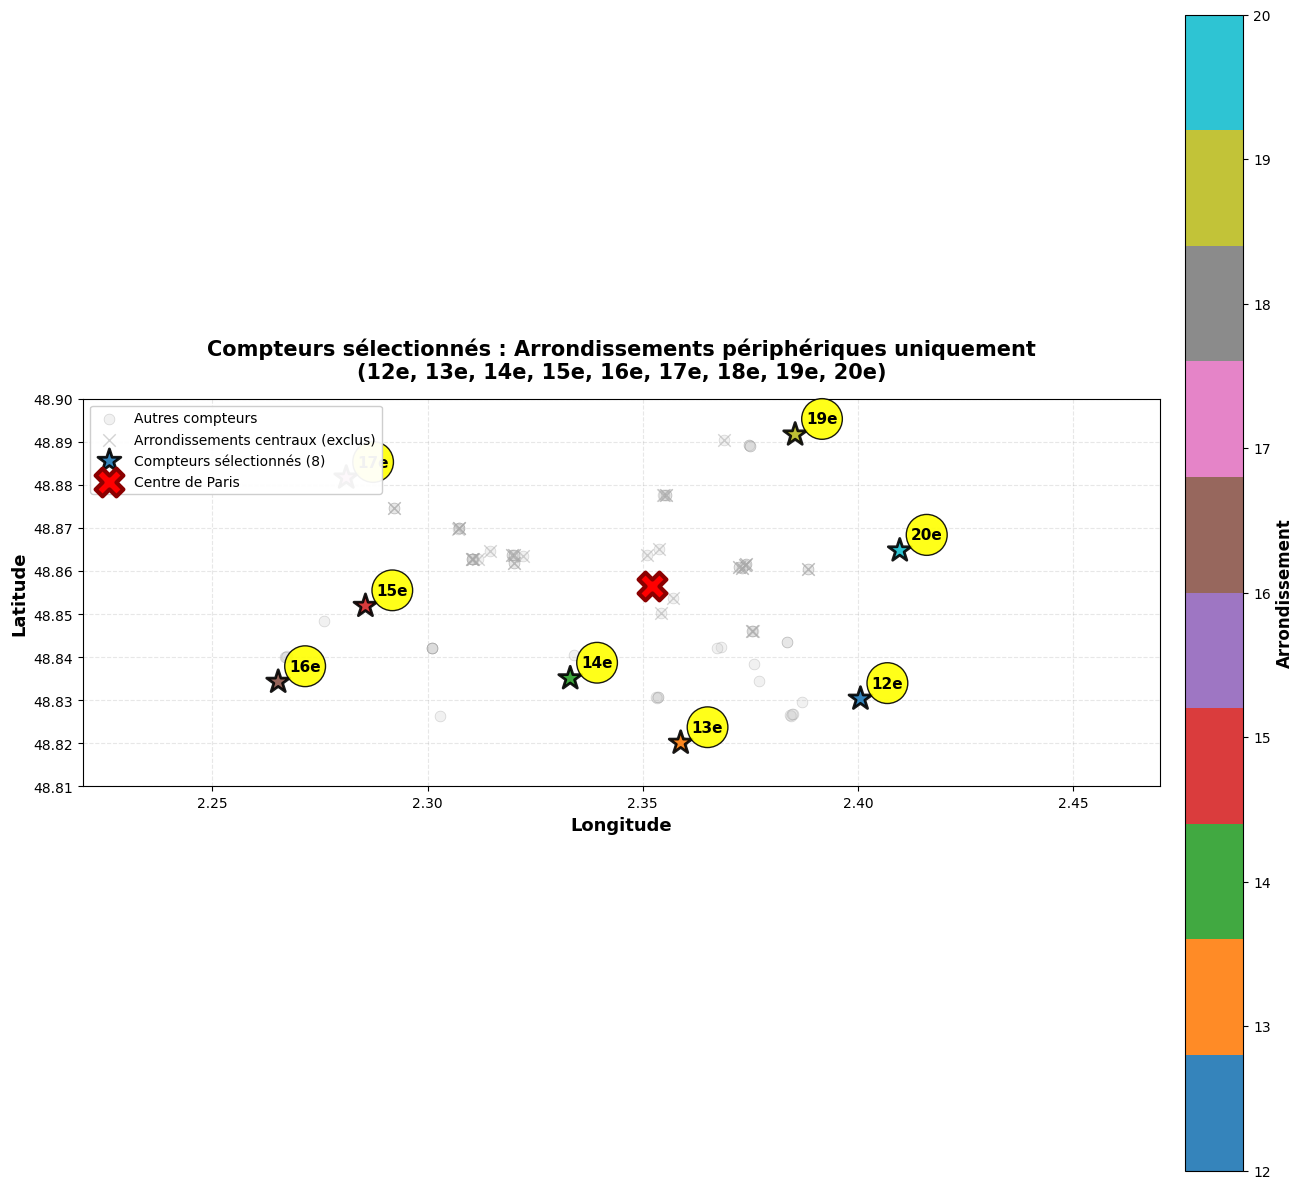


STATISTIQUES

Arrondissements sélectionnés : [12, 13, 14, 15, 16, 17, 19, 20]
Nombre de compteurs : 8
 Arrondissements périphériques sans compteur constant : [18]

Distance moyenne au centre : 0.0574°
Distance min : 0.0288°
Distance max : 0.0897°

Lignes de comptage après sélection : 1,439,110


5. Fusion avec données météo...
  Lignes avec météo (comptage > 0) : 287,923

6. Transformation logarithmique...
  Comptage avant log : min=1, max=2563
  Log comptage : min=0.00, max=7.85
  Lignes finales pour régression : 287,923

7. RÉGRESSION LOG-NIVEAU

Nombre de variables : 30
Nombre d'observations : 287,923

RÉSULTATS DE LA RÉGRESSION LOG-NIVEAU

R² : 0.0703
R² ajusté : 0.0702
F-statistic : 725.21
Prob (F-statistic) : 0.00e+00

COEFFICIENTS DES VARIABLES MÉTÉO

 INTERPRÉTATION (modèle log-niveau) :
   Coefficient = % de variation du trafic pour +1 unité de la variable

Température :
  Coefficient : +0.0135
  P-value     : 0.0000 ***
   +1°C → +1.36% de passages vélo

Précipitation :
  Co

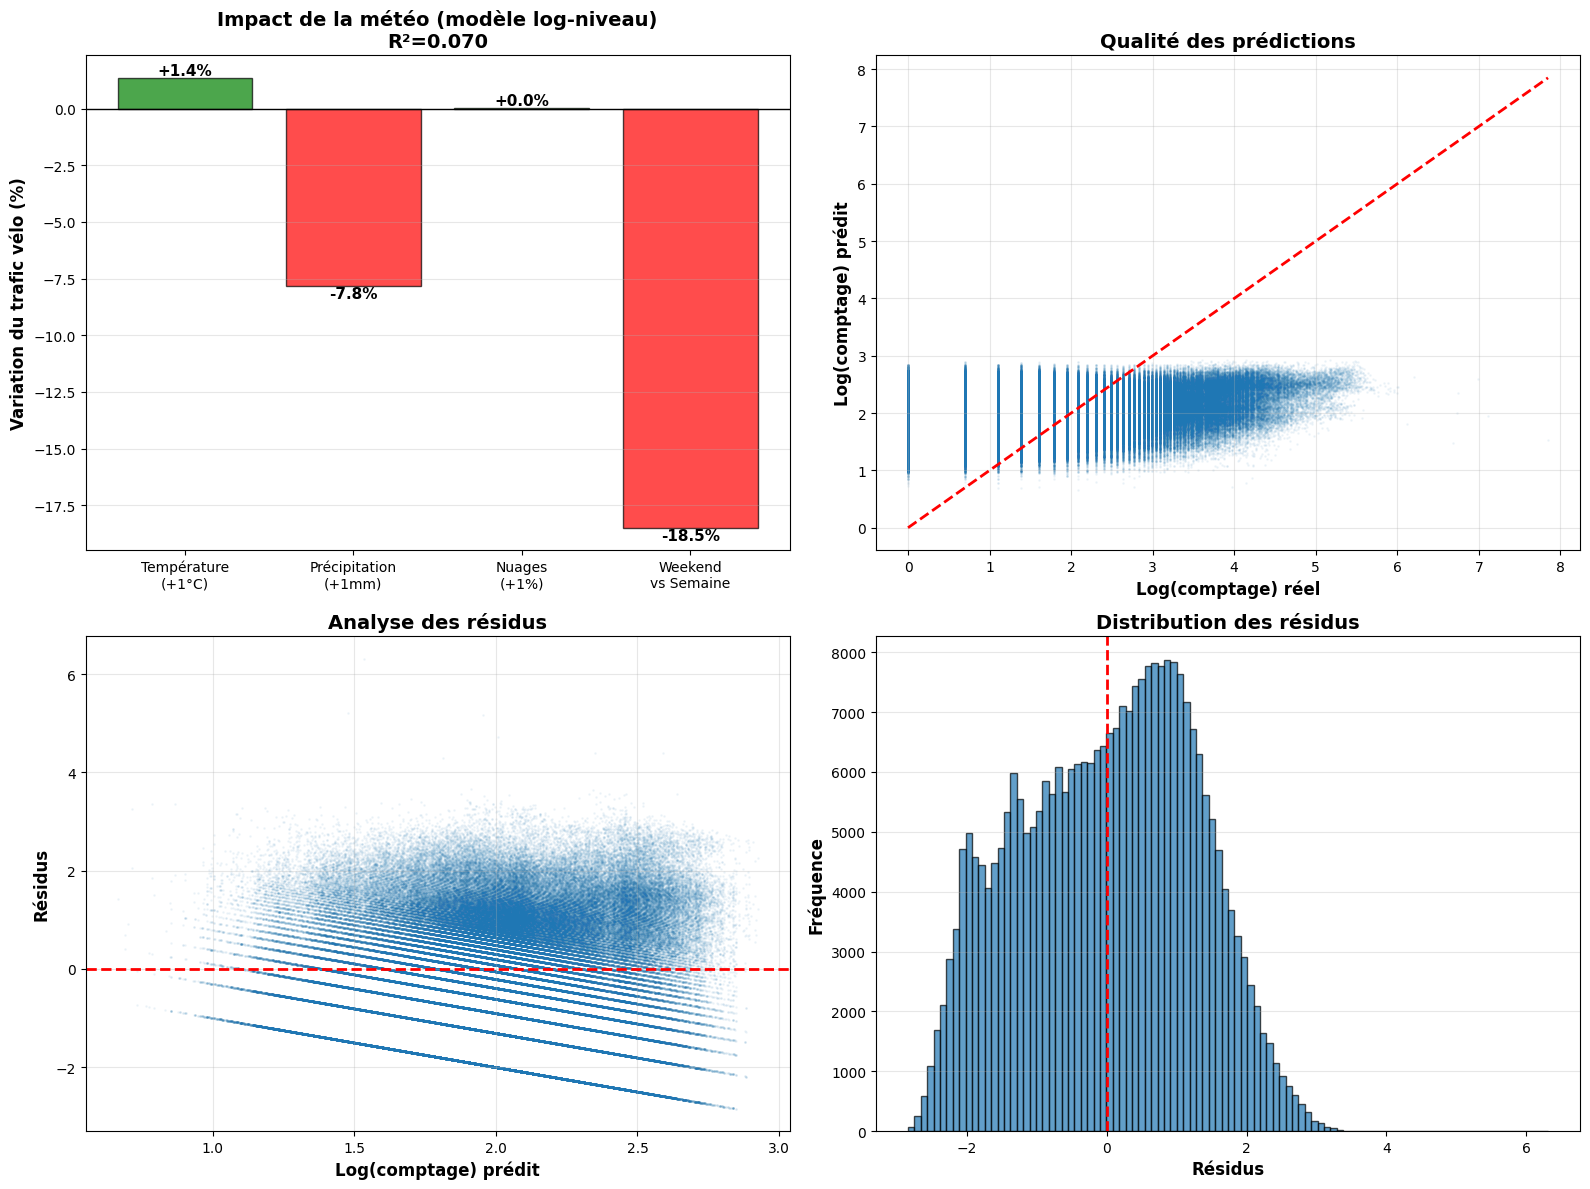


ANALYSE TERMINÉE

 RÉSUMÉ :
  • Modèle : log(comptage) = f(température, précipitation, nuages, weekend, heures, mois)
  • Compteurs : 8 (1 par arrondissement, aux extrémités)
  • R² = 0.070 (le modèle explique 7.0% de la variance)
  • +1°C → +1.36% de vélo
  • +1mm pluie → -7.81% de vélo
  • +1% nuages → +0.02% de vélo
  • Weekend → -18.49% de vélo


In [14]:
print("="*80)
print("RÉGRESSION LOG-NIVEAU : IMPACT DE LA MÉTÉO SUR LE TRAFIC VÉLO")
print("="*80)

# ============================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================

DATA_DIR = "data"

print("\n1. Chargement des données...")

# Température
temp_files = sorted(glob.glob(f"{DATA_DIR}/*_temperature_horaire_par_site_comptage.csv"))
temp_list = [pd.read_csv(f, sep=',', on_bad_lines='skip') for f in temp_files]
df_temperature = pd.concat(temp_list, ignore_index=True)

# Précipitations
precip_files = sorted(glob.glob(f"{DATA_DIR}/*_precipitation_horaire_par_site_comptage.csv"))
precip_list = [pd.read_csv(f, sep=',', on_bad_lines='skip') for f in precip_files]
df_precipitation = pd.concat(precip_list, ignore_index=True)

# Couverture nuageuse
cloud_files = sorted(glob.glob(f"{DATA_DIR}/*_cloud_cover_horaire_par_site_comptage.csv"))
cloud_list = [pd.read_csv(f, sep=',', on_bad_lines='skip') for f in cloud_files]
df_cloud_cover = pd.concat(cloud_list, ignore_index=True)

# Comptage
comptage_files = sorted(glob.glob(f"{DATA_DIR}/*comptage-velo-donnees-sites-comptage.csv"))
comptage_list = []
for f in comptage_files:
    if '2023' in f:
        df_c = pd.read_csv(f, sep=',', on_bad_lines='skip', dtype=str)
    else:
        df_c = pd.read_csv(f, sep=';', on_bad_lines='skip', dtype=str)
    comptage_list.append(df_c)
df_comptage = pd.concat(comptage_list, ignore_index=True)

print(f"  Comptage : {len(df_comptage):,} lignes")

# ============================================================
# 2. NETTOYAGE
# ============================================================

print("\n2. Nettoyage des données...")

# Normaliser colonnes
df_comptage.columns = df_comptage.columns.str.strip()
df_temperature.columns = df_temperature.columns.str.strip()
df_precipitation.columns = df_precipitation.columns.str.strip()
df_cloud_cover.columns = df_cloud_cover.columns.str.strip()

# Renommer
df_temperature = df_temperature.rename(columns={'nom_point_comptage': 'nom_site', 'temperature_apparente': 'temperature'})
df_precipitation = df_precipitation.rename(columns={'nom_point_comptage': 'nom_site', 'precipitation_mm': 'precipitation'})
df_cloud_cover = df_cloud_cover.rename(columns={'nom_point_comptage': 'nom_site', 'cloud_cover_pct': 'cloud_cover'})
df_comptage = df_comptage.rename(columns={
    'Identifiant du point de comptage': 'id_compteur',
    'Nom du point de comptage': 'nom_site',
    'Comptage horaire': 'comptage',
    'Date et heure de comptage': 'datetime',
    'Coordonnées géographiques': 'coordonnees'
})

# Convertir dates
df_comptage['datetime'] = pd.to_datetime(df_comptage['datetime'], format='ISO8601', utc=True, errors='coerce').dt.tz_localize(None)
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'], errors='coerce')
df_precipitation['datetime'] = pd.to_datetime(df_precipitation['datetime'], errors='coerce')
df_cloud_cover['datetime'] = pd.to_datetime(df_cloud_cover['datetime'], errors='coerce')

# Extraire composantes temporelles
df_comptage['annee'] = df_comptage['datetime'].dt.year
df_comptage['mois'] = df_comptage['datetime'].dt.month
df_comptage['heure'] = df_comptage['datetime'].dt.hour
df_comptage['jour_semaine'] = df_comptage['datetime'].dt.dayofweek

# Filtrer 2021-2024
df_comptage = df_comptage[df_comptage['annee'].isin([2021, 2022, 2023, 2024])]

# FILTRER HEURES 7h-22h
df_comptage = df_comptage[(df_comptage['heure'] >= 7) & (df_comptage['heure'] <= 22)]
print(f"  Après filtrage 7h-22h : {len(df_comptage):,} lignes")

# Convertir valeurs
df_comptage['comptage_num'] = pd.to_numeric(df_comptage['comptage'], errors='coerce')
df_temperature['temperature'] = pd.to_numeric(df_temperature['temperature'], errors='coerce')
df_precipitation['precipitation'] = pd.to_numeric(df_precipitation['precipitation'], errors='coerce')
df_cloud_cover['cloud_cover'] = pd.to_numeric(df_cloud_cover['cloud_cover'], errors='coerce')

# Parser coordonnées
coords_split = df_comptage['coordonnees'].astype(str).str.split(',', expand=True)
df_comptage['latitude'] = pd.to_numeric(coords_split[0], errors='coerce')
df_comptage['longitude'] = pd.to_numeric(coords_split[1], errors='coerce')
df_comptage = df_comptage.dropna(subset=['datetime', 'comptage_num', 'latitude', 'longitude'])

# ============================================================
# 3. SÉLECTION COMPTEURS CONSTANTS
# ============================================================

print("\n3. Identification des compteurs constants...")

# Compteurs constants 2021-2024
compteurs_annees = df_comptage.groupby('id_compteur')['annee'].apply(lambda x: set(x.unique()))
annees_completes = {2021, 2022, 2023, 2024}
compteurs_constants = [c for c, a in compteurs_annees.items() if annees_completes.issubset(a)]
df_comptage = df_comptage[df_comptage['id_compteur'].isin(compteurs_constants)]
print(f"  Compteurs constants : {len(compteurs_constants)}")

# Coordonnées moyennes par compteur
compteurs_coords = df_comptage.groupby(['id_compteur', 'nom_site']).agg({
    'latitude': 'mean', 
    'longitude': 'mean'
}).reset_index()

# ============================================================
# 4. SÉLECTION : UN COMPTEUR PAR ARRONDISSEMENT PÉRIPHÉRIQUE
# ============================================================

print("\n4. SÉLECTION DES COMPTEURS")
print("="*80)

# Calculer l'arrondissement pour chaque compteur
centroides = np.array([
    [48.8608, 2.3418, 1], [48.8681, 2.3424, 2], [48.8634, 2.3596, 3],
    [48.8567, 2.3612, 4], [48.8458, 2.3497, 5], [48.8503, 2.3318, 6],
    [48.8566, 2.3165, 7], [48.8722, 2.3121, 8], [48.8754, 2.3417, 9],
    [48.8760, 2.3618, 10], [48.8575, 2.3820, 11], [48.8397, 2.3882, 12],
    [48.8322, 2.3665, 13], [48.8338, 2.3268, 14], [48.8407, 2.2862, 15],
    [48.8513, 2.2646, 16], [48.8873, 2.3089, 17], [48.8903, 2.3448, 18],
    [48.8828, 2.3839, 19], [48.8649, 2.3969, 20],
])

lats = compteurs_coords['latitude'].values[:, np.newaxis]
lons = compteurs_coords['longitude'].values[:, np.newaxis]
distances_arrond = np.sqrt((lats - centroides[:, 0])**2 + (lons - centroides[:, 1])**2)
compteurs_coords['arrondissement'] = centroides[np.argmin(distances_arrond, axis=1), 2].astype(int)

# Calculer la distance au centre de Paris pour chaque compteur
lat_center, lon_center = 48.8566, 2.3522
compteurs_coords['dist_center'] = np.sqrt(
    (compteurs_coords['latitude'] - lat_center)**2 + 
    (compteurs_coords['longitude'] - lon_center)**2
)

# FILTRER UNIQUEMENT LES ARRONDISSEMENTS PÉRIPHÉRIQUES
arrondissements_peripheriques = [12, 13, 14, 15, 16, 17, 18, 19, 20]
compteurs_coords_filtre = compteurs_coords[
    compteurs_coords['arrondissement'].isin(arrondissements_peripheriques)
]

print(f"  Compteurs constants 2021-2024 : {len(compteurs_constants)}")
print(f"  Arrondissements périphériques sélectionnés : {arrondissements_peripheriques}")
print(f"  Compteurs dans ces arrondissements : {len(compteurs_coords_filtre)}")

# Pour chaque arrondissement, prendre le compteur le PLUS ÉLOIGNÉ du centre de Paris
compteurs_extremites = compteurs_coords_filtre.loc[
    compteurs_coords_filtre.groupby('arrondissement')['dist_center'].idxmax()
].reset_index(drop=True)

print(f"  Compteurs sélectionnés (1 par arrondissement périphérique) : {len(compteurs_extremites)}")

print("\n" + "="*80)
print("COMPTEURS SÉLECTIONNÉS (ARRONDISSEMENTS PÉRIPHÉRIQUES UNIQUEMENT)")
print("="*80)

compteurs_extremites_sorted = compteurs_extremites.sort_values('arrondissement')
for i, (_, row) in enumerate(compteurs_extremites_sorted.iterrows(), 1):
    print(f"{row['arrondissement']:2.0f}e arr. | {row['nom_site'][:60]:<60} | "
          f"Lat: {row['latitude']:.4f}, Lon: {row['longitude']:.4f} | "
          f"Distance centre: {row['dist_center']:.4f}°")

# Visualisation sur carte
fig, ax = plt.subplots(figsize=(14, 12))

# Tous les compteurs en gris clair
ax.scatter(compteurs_coords['longitude'], compteurs_coords['latitude'], 
           s=60, alpha=0.3, color='lightgray', edgecolors='gray', linewidths=0.5,
           label=f'Autres compteurs')

# Compteurs des arrondissements non-sélectionnés en gris foncé
compteurs_non_selectionnes = compteurs_coords[
    ~compteurs_coords['arrondissement'].isin(arrondissements_peripheriques)
]
ax.scatter(compteurs_non_selectionnes['longitude'], 
           compteurs_non_selectionnes['latitude'], 
           s=80, alpha=0.5, color='darkgray', 
           marker='x', linewidths=1,
           label=f'Arrondissements centraux (exclus)')

# Compteurs sélectionnés colorés par arrondissement
scatter = ax.scatter(compteurs_extremites_sorted['longitude'], 
                     compteurs_extremites_sorted['latitude'], 
                     s=300, alpha=0.9, 
                     c=compteurs_extremites_sorted['arrondissement'],
                     cmap='tab10', marker='*', 
                     edgecolors='black', linewidths=2,
                     label=f'Compteurs sélectionnés ({len(compteurs_extremites)})', 
                     zorder=3)

# Centre de Paris
ax.scatter(lon_center, lat_center, s=400, marker='X', color='red', 
           linewidths=3, label='Centre de Paris', zorder=5, edgecolors='darkred')

# Annoter chaque compteur avec son arrondissement
for _, row in compteurs_extremites_sorted.iterrows():
    ax.annotate(f"{int(row['arrondissement'])}e", 
                xy=(row['longitude'], row['latitude']),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='circle,pad=0.3', facecolor='yellow', 
                         edgecolor='black', alpha=0.9))

# Colorbar pour les arrondissements
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Arrondissement', fontsize=12, fontweight='bold')

ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.set_title('Compteurs sélectionnés : Arrondissements périphériques uniquement\n(12e, 13e, 14e, 15e, 16e, 17e, 18e, 19e, 20e)', 
             fontsize=15, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Limites de Paris
ax.set_xlim(2.22, 2.47)
ax.set_ylim(48.81, 48.90)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Statistiques
print("\n" + "="*80)
print("STATISTIQUES")
print("="*80)

print(f"\nArrondissements sélectionnés : {sorted(compteurs_extremites['arrondissement'].astype(int).tolist())}")
print(f"Nombre de compteurs : {len(compteurs_extremites)}")

arrondissements_manquants = set(arrondissements_peripheriques) - set(compteurs_extremites['arrondissement'].astype(int))
if arrondissements_manquants:
    print(f" Arrondissements périphériques sans compteur constant : {sorted(arrondissements_manquants)}")
else:
    print(" Tous les arrondissements périphériques sont couverts !")

# Distance moyenne au centre
print(f"\nDistance moyenne au centre : {compteurs_extremites['dist_center'].mean():.4f}°")
print(f"Distance min : {compteurs_extremites['dist_center'].min():.4f}°")
print(f"Distance max : {compteurs_extremites['dist_center'].max():.4f}°")

# Filtrer les données pour ces compteurs
compteurs_extremites_ids = compteurs_extremites['id_compteur'].tolist()
df_comptage = df_comptage[df_comptage['id_compteur'].isin(compteurs_extremites_ids)]

print(f"\nLignes de comptage après sélection : {len(df_comptage):,}")
print("\n" + "="*80)

# ============================================================
# 5. FUSION AVEC MÉTÉO
# ============================================================

print("\n5. Fusion avec données météo...")

df_merged = df_comptage.merge(
    df_temperature[['datetime', 'nom_site', 'temperature']],
    on=['datetime', 'nom_site'], how='left'
).merge(
    df_precipitation[['datetime', 'nom_site', 'precipitation']],
    on=['datetime', 'nom_site'], how='left'
).merge(
    df_cloud_cover[['datetime', 'nom_site', 'cloud_cover']],
    on=['datetime', 'nom_site'], how='left'
)

df_merged = df_merged.dropna(subset=['temperature', 'precipitation', 'cloud_cover', 'comptage_num'])
df_merged = df_merged[df_merged['comptage_num'] > 0]
print(f"  Lignes avec météo (comptage > 0) : {len(df_merged):,}")

# ============================================================
# 6. TRANSFORMATION LOG ET VARIABLES DE CONTRÔLE
# ============================================================

print("\n6. Transformation logarithmique...")

# TRANSFORMATION LOG-NIVEAU
df_merged['log_comptage'] = np.log(df_merged['comptage_num'])

print(f"  Comptage avant log : min={df_merged['comptage_num'].min():.0f}, max={df_merged['comptage_num'].max():.0f}")
print(f"  Log comptage : min={df_merged['log_comptage'].min():.2f}, max={df_merged['log_comptage'].max():.2f}")

# Weekend
df_merged['is_weekend'] = (df_merged['jour_semaine'] >= 5).astype(float)

# Variables catégorielles
heure_dummies = pd.get_dummies(df_merged['heure'], prefix='heure', drop_first=True, dtype=float)
mois_dummies = pd.get_dummies(df_merged['mois'], prefix='mois', drop_first=True, dtype=float)

# Combiner
df_regression = pd.concat([
    df_merged[['log_comptage', 'temperature', 'precipitation', 'cloud_cover', 'is_weekend']], 
    heure_dummies, mois_dummies
], axis=1)

# S'assurer que tout est numérique
for col in df_regression.columns:
    df_regression[col] = pd.to_numeric(df_regression[col], errors='coerce')

df_regression = df_regression.dropna()
print(f"  Lignes finales pour régression : {len(df_regression):,}")

# ============================================================
# 7. RÉGRESSION LOG-NIVEAU
# ============================================================

print("\n7. RÉGRESSION LOG-NIVEAU")
print("="*80)

# Variables indépendantes
feature_cols = ['temperature', 'precipitation', 'cloud_cover', 'is_weekend']
feature_cols += [col for col in df_regression.columns if col.startswith('heure_')]
feature_cols += [col for col in df_regression.columns if col.startswith('mois_')]

X = df_regression[feature_cols].values
y = df_regression['log_comptage'].values

print(f"\nNombre de variables : {len(feature_cols)}")
print(f"Nombre d'observations : {len(X):,}")

# Régression avec statsmodels
X_with_const = sm.add_constant(X)
model_stats = sm.OLS(y, X_with_const).fit()

print("\n" + "="*80)
print("RÉSULTATS DE LA RÉGRESSION LOG-NIVEAU")
print("="*80)

print(f"\nR² : {model_stats.rsquared:.4f}")
print(f"R² ajusté : {model_stats.rsquared_adj:.4f}")
print(f"F-statistic : {model_stats.fvalue:.2f}")
print(f"Prob (F-statistic) : {model_stats.f_pvalue:.2e}")

print("\n" + "="*80)
print("COEFFICIENTS DES VARIABLES MÉTÉO")
print("="*80)

# Les coefficients (const, temp, precip, cloud, weekend, puis heures et mois)
coef_temp = model_stats.params[1]
coef_precip = model_stats.params[2]
coef_cloud = model_stats.params[3]
coef_weekend = model_stats.params[4]

pval_temp = model_stats.pvalues[1]
pval_precip = model_stats.pvalues[2]
pval_cloud = model_stats.pvalues[3]
pval_weekend = model_stats.pvalues[4]

def significatif(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return 'NS'

# INTERPRÉTATION LOG-NIVEAU
print(f"\n INTERPRÉTATION (modèle log-niveau) :")
print(f"   Coefficient = % de variation du trafic pour +1 unité de la variable\n")

print(f"Température :")
print(f"  Coefficient : {coef_temp:+.4f}")
print(f"  P-value     : {pval_temp:.4f} {significatif(pval_temp)}")
print(f"   +1°C → {(np.exp(coef_temp)-1)*100:+.2f}% de passages vélo")

print(f"\nPrécipitation :")
print(f"  Coefficient : {coef_precip:+.4f}")
print(f"  P-value     : {pval_precip:.4f} {significatif(pval_precip)}")
print(f"   +1mm de pluie → {(np.exp(coef_precip)-1)*100:+.2f}% de passages vélo")

print(f"\nCouverture nuageuse :")
print(f"  Coefficient : {coef_cloud:+.4f}")
print(f"  P-value     : {pval_cloud:.4f} {significatif(pval_cloud)}")
print(f"   +1% de nuages → {(np.exp(coef_cloud)-1)*100:+.2f}% de passages vélo")

print(f"\nWeekend :")
print(f"  Coefficient : {coef_weekend:+.4f}")
print(f"  P-value     : {pval_weekend:.4f} {significatif(pval_weekend)}")
print(f"   Weekend vs Semaine → {(np.exp(coef_weekend)-1)*100:+.2f}% de passages vélo")

# ============================================================
# 8. VISUALISATIONS
# ============================================================

print("\n8. Génération des graphiques...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1 : Coefficients en %
ax1 = axes[0, 0]
variables = ['Température\n(+1°C)', 'Précipitation\n(+1mm)', 'Nuages\n(+1%)', 'Weekend\nvs Semaine']
pct_changes = [(np.exp(c)-1)*100 for c in [coef_temp, coef_precip, coef_cloud, coef_weekend]]
colors = ['green' if c > 0 else 'red' for c in pct_changes]
bars = ax1.bar(variables, pct_changes, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Variation du trafic vélo (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Impact de la météo (modèle log-niveau)\nR²={model_stats.rsquared:.3f}', 
              fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars, pct_changes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{pct:+.1f}%', ha='center', va='bottom' if height > 0 else 'top',
             fontweight='bold', fontsize=11)

# Graphique 2 : Prédictions vs Réel (en log)
ax2 = axes[0, 1]
y_pred = model_stats.fittedvalues
ax2.scatter(y, y_pred, alpha=0.05, s=1)
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
ax2.set_xlabel('Log(comptage) réel', fontsize=12, fontweight='bold')
ax2.set_ylabel('Log(comptage) prédit', fontsize=12, fontweight='bold')
ax2.set_title('Qualité des prédictions', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Graphique 3 : Résidus
ax3 = axes[1, 0]
residus = model_stats.resid
ax3.scatter(y_pred, residus, alpha=0.05, s=1)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Log(comptage) prédit', fontsize=12, fontweight='bold')
ax3.set_ylabel('Résidus', fontsize=12, fontweight='bold')
ax3.set_title('Analyse des résidus', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Graphique 4 : Distribution résidus
ax4 = axes[1, 1]
ax4.hist(residus, bins=100, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Résidus', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax4.set_title('Distribution des résidus', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSE TERMINÉE")
print("="*80)

print(f"\n RÉSUMÉ :")
print(f"  • Modèle : log(comptage) = f(température, précipitation, nuages, weekend, heures, mois)")
print(f"  • Compteurs : {len(compteurs_extremites)} (1 par arrondissement, aux extrémités)")
print(f"  • R² = {model_stats.rsquared:.3f} (le modèle explique {model_stats.rsquared*100:.1f}% de la variance)")
print(f"  • +1°C → {(np.exp(coef_temp)-1)*100:+.2f}% de vélo")
print(f"  • +1mm pluie → {(np.exp(coef_precip)-1)*100:+.2f}% de vélo")
print(f"  • +1% nuages → {(np.exp(coef_cloud)-1)*100:+.2f}% de vélo")
print(f"  • Weekend → {(np.exp(coef_weekend)-1)*100:+.2f}% de vélo")

**Performance du modèle**

R² = 0.070 (7.0% de la variance expliquée)

R² relativement faible : La météo et les variables temporelles n'expliquent qu'une petite partie du trafic vélo. D'autres facteurs non modélisés influencent fortement les déplacements (événements, vacances, grèves, tendances individuelles, etc.).

---

**Température : +1.36%** 
- +1°C → +1.36% de passages vélo
- Effet positif modéré
- La chaleur encourage les déplacements à vélo

**Précipitation : -7.81%** 
- +1mm de pluie → -7.81% de passages vélo
- Effet le plus fort parmi les variables météo
- La pluie est un frein majeur à la pratique du vélo

**Couverture nuageuse : +0.02%** 
- Effet quasi nul
- Les nuages seuls (sans pluie) n'influencent pas les cyclistes

**Weekend : -18.49%** 
- Weekend → -18.5% de passages vélo vs jours ouvrés
- Confirme la forte composante "trajets domicile-travail" du trafic vélo

---

**Diagnostics du modèle :**
- Résidus : Distribution normale centrée sur 0 → modèle bien spécifié
- Pas de biais systématique : Nuage de points dispersé aléatoirement
- Significativité : Tous les coefficients météo sont hautement significatifs (p < 0.001)

## Conclusion

**Résultats principaux :**

Ce projet a permis d'analyser l'évolution du trafic vélo à Paris entre 2018 et 2024 et de quantifier l'impact de deux facteurs majeurs : la météo et le télétravail.

L'analyse économétrique (régression log-niveau) a quantifié l'effet des conditions météorologiques sur le trafic cyclable :

- Température : +1°C → +1.4% de passages vélo (effet positif modéré)
- Précipitation : +1mm de pluie → -7.8% de passages vélo (effet négatif fort)
- Couverture nuageuse : Effet négligeable (+0.02%)

La pluie constitue donc le frein météorologique le plus important à la pratique du vélo, tandis que la température a un effet positif mais modéré. Les nuages seuls (sans pluie) n'influencent pas les comportements.

L'analyse des patterns temporels a révélé une modification structurelle des habitudes de déplacement post-COVID :

- Part du vélo-taff : Baisse de 44% (2018-2020) à 36% (2021-2023), puis remontée à 43% (2024)
- Ratio Lun+Ven / Mar+Mer+Jeu : Diminution de 0.92 (2018) à 0.85-0.89 (2021-2024)
- Interprétation : Le télétravail réduit le trafic vélo de ~11-12% le lundi et vendredi

Le télétravail s'est ancré durablement dans les habitudes professionnelles et a modifié les patterns hebdomadaires de déplacement, avec une concentration accrue du trafic vélo sur les jours mardi-mercredi-jeudi.


---

**Limites de l'étude :**

Le modèle de régression n'explique que 7% de la variance du trafic vélo. Cela signifie que 93% des variations sont dues à d'autres facteurs non modélisés.

Hypothèse sur les facteurs manquants :
- Évolution des infrastructures cyclables (coronapistes, nouvelles pistes, réaménagements) ;
- Vacances scolaires : Impact majeur non capturé (exclusion partielle avec juillet-août)
- Grèves de transports en commun : Pics de trafic vélo lors des grèves RATP/SNCF
- Événements : Manifestations, travaux routiers, fermetures de stations de métro
- Qualité de l'air : Pics de pollution (jours sans voiture, etc.)
- Jours fériés: Non distingués des weekends classiques
- Tendances individuelles : Habitudes personnelles, adoption progressive du vélo




Ainsi, nous avons quantifié l'effet de la température, des précipitations et de la couverture nuageuse. Cependant, le R² faible (7%) montre que d'autres facteurs dominent. La météo n'est qu'un déterminant parmi d'autres. Les effets combinés (température ET pluie simultanées), les seuils non-linéaires (forte chaleur >30°C ?), vent (non mesuré) ne sont pas pris en compte.

Nous avons également mis en lumière une modification structurelle des patterns hebdomadaires dûe probablement au fait de la généralisation du télétravail.

---

**Pistes d'amélioration futures :**


1. Enrichir le modèle météo :
   - Ajouter le vent (vitesse et direction)
   - Tester des interactions (température × pluie)
   - Inclure des seuils non-linéaires (forte chaleur, grand froid)


2. Ajouter des variables binaires :
   - Vacances scolaires
   - Jours fériés
   - Grèves RATP/SNCF
   - Pics de pollution


3. Intégrer les données d'infrastructure :
   - Géolocalisation des pistes cyclables avec dates de création
   - Calculer un score d'accessibilité vélo par compteur
   - Mesurer l'effet réseau (connectivité)


4. Utiliser des données de mobilité globale :
   - Comparer avec l'évolution des autres modes (métro, bus, voiture)


5. Enquêtes qualitatives :
   - Interviews de cyclistes : Pourquoi rouler sous la pluie ? Qu'est-ce qui vous ferait arrêter ?
   - Segmentation par profil (typologie de Geller : "Interested but Concerned" vs "Enthused and Confident")


---

Ce projet a permis de quantifier l'impact de la météo et du télétravail sur le trafic vélo parisien. Les résultats confirment l'intuition que la pluie est le principal frein météorologique (-7.8% par mm) et que le télétravail a modifié durablement les patterns hebdomadaires.

Cependant, le R² faible (7%) rappelle que les déplacements à vélo sont déterminés par une multitude de facteurs (infrastructures, habitudes, événements, vacances, grèves). La météo n'est qu'un facteur parmi d'autres.

Pour encourager la pratique du vélo, il ne suffit pas d'attendre le beau temps. Il faut agir sur les infrastructures (pistes séparées, sécurité) et l'attractivité du vélo par rapport aux autres modes de transport.
